# Exploration et analyse des données - Time Series (ML II)

## 1. Introduction et Objectifs

- Présentation du projet de prévision météorologique
- Objectifs : créer un modèle de prévision avec pipeline MLOps
- Modules concernés : Machine Learning II, MLOps, DevOps

## 2. Préparation des Données

### 2.1 Import des bibliothèques

In [1]:
import optuna
import sys
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from feature_engine.timeseries.forecasting import LagFeatures

from model.entity.base import Base
from model.entity.data_process_timeseries import DataProcessTimeseries
from model.entity.data_reel_timeseries import DataReelTimeseries

from model.helpers.dataset_helper import nan_interpolation_linear, extract_object_to_dataframe
from model.helpers.open_meteo_helper import metrics_result
from model.helpers.time_series_helper import check_stationarity, check_stationarity_kpss

from model.repository.data_reel_timeseries_repository import DataReelTimeseriesRepository
from model.repository.data_process_timeseries_repository import DataProcessTimeSeriesRepository
from model.repository.logging_timeseries_repository import LoggingTimeseriesRepository
from model.services.database_manager import DatabaseManager

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from sqlalchemy import inspect

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

from model.services.logger_manager import LoggerManager
from visualizations.monitoring.monitoring import match_val_predict

from xgboost import XGBRegressor

sys.path.append("../../")

optuna.logging.disable_default_handler()
optuna.logging.set_verbosity(optuna.logging.WARNING)

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2.2 Récupération des données météo

Les données météo son récupéré de l'API pou être stocké dans facon brute dans la table **row**

In [2]:
db_manager = DatabaseManager()
db_manager.init_connection()

logger_manager = LoggerManager(db_manager.session)

Base.metadata.create_all(db_manager.engine)

inspector = inspect(db_manager.engine)

tunner_logging_repository = LoggingTimeseriesRepository(db_manager.session)
data_reel_repository = DataReelTimeseriesRepository(db_manager.session)
data_process_repository = DataProcessTimeSeriesRepository(db_manager.session)

Récupération des informations brute depuit la base de données et attribution des noms de colones

In [3]:

start = datetime(2023, 1, 1)
end = datetime(2024, 12, 31)
result = data_reel_repository.get_between_dates(start, end)
df = extract_object_to_dataframe(result, ['time', 'temperature_2m', 'relative_humidity_2m'])
df.head(n=4)

,time,temperature_2m,relative_humidity_2m
0,2023-01-01 00:00:00,15.3085,58.668945
1,2023-01-01 01:00:00,15.7085,54.692139
2,2023-01-01 02:00:00,15.7585,52.490711
3,2023-01-01 03:00:00,15.8585,50.558018


In [4]:
df_preprocess = df.copy()

In [5]:
df_preprocess = nan_interpolation_linear(df_preprocess, 'time')
df_preprocess = nan_interpolation_linear(df_preprocess, 'relative_humidity_2m')

In [6]:
df_preprocess = df_preprocess.rename(columns={'time': 'ds', 'temperature_2m': 'y'})
df_preprocess['ds'] = pd.to_datetime(df_preprocess['ds'])
df_preprocess = df_preprocess.set_index('ds')

In [7]:
df_preprocess = df_preprocess.resample('3h').mean()

In [8]:
df_preprocess = df_preprocess.reset_index()
df_preprocess.head()

,ds,y,relative_humidity_2m
0,2023-01-01 00:00:00,15.591833,55.283932
1,2023-01-01 03:00:00,15.425167,51.678267
2,2023-01-01 06:00:00,14.508500,56.620635
3,2023-01-01 09:00:00,14.908500,59.450488
4,2023-01-01 12:00:00,15.091834,62.193785


## 3. Analyse Exploratoire des Données (EDA)

Recupération des tableaux dans la base de donnée.

In [9]:
df_eda = df_preprocess.copy()
df_eda = df_eda.set_index('ds')

full_index = pd.date_range(start=df_eda.index.min(),
                           end=df_eda.index.max(),
                           freq='3h')
df_eda = df_eda.reindex(full_index).ffill()

df_eda['unique_id'] = 0
df_y = df_eda.drop(columns=['relative_humidity_2m']).copy()

df_exog = df_eda.drop(columns=['y']).copy()


### 3.1 Statistiques descriptives

#### Dataframe des measures

In [10]:
print(df_eda.isna().sum())
df_eda.describe()

y                       0
relative_humidity_2m    0
unique_id               0
dtype: int64


,y,relative_humidity_2m,unique_id
count,5841.000000,5841.000000,5841.0
mean,11.513034,75.446899,0.0
std,7.957001,16.807259,0.0
min,-10.224833,23.019784,0.0
25%,5.375167,64.842275,0.0
50%,10.958500,79.649356,0.0
75%,17.541834,89.152049,0.0
max,34.075165,100.000000,0.0


In [11]:
df_eda.head(n=3)

,y,relative_humidity_2m,unique_id
2023-01-01 00:00:00,15.591833,55.283932,0
2023-01-01 03:00:00,15.425167,51.678267,0
2023-01-01 06:00:00,14.508500,56.620635,0


### 3.2 Visualisations

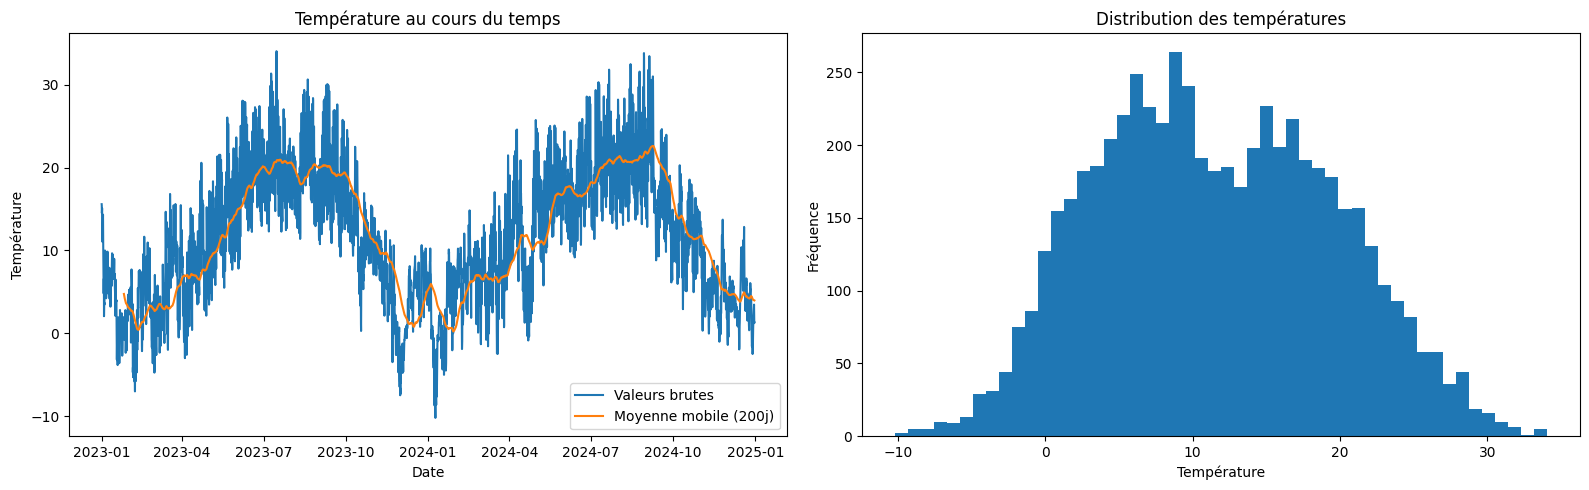

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))  # 1 ligne, 2 colonnes

# Premier graphique : série temporelle
axes[0].plot(df_y.index, df_eda['y'], label='Valeurs brutes')
axes[0].plot(df_y.index, df_eda['y'].rolling(window=200).mean(), label='Moyenne mobile (200j)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Température')
axes[0].set_title('Température au cours du temps')
axes[0].legend()

# Deuxième graphique : histogramme
axes[1].hist(df_y['y'], bins=50)
axes[1].set_title('Distribution des températures')
axes[1].set_xlabel('Température')
axes[1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()


La série n’est pas stationnaire.

On observe une forte saisonnalité avec des cycles annuels bien marqués: la moyenne et la variance évoluent clairement au fil du temps, ce qui viole les conditions de stationnarité.

Le graphique de droite montre une distribution bimodale des températures avec deux pics distincts. Le premier pic se situe autour de 5-10°C (probablement les températures hivernales) et le second autour de 15-20°C (températures estivales).

Cette forme bimodale confirme la forte saisonnalité observée dans la série temporelle : les températures se regroupent principalement autour de deux valeurs caractéristiques correspondant aux saisons froides et chaudes.

La distribution couvre une amplitude importante (-10°C à 30°C), ce qui illustre bien la variabilité saisonnière importante de cette série de températures. Cette caractéristique bimodale est typique des données climatiques dans les régions à saisons marquées.

 > On observe que les températures descendent parfois proches de 0°C, voire en dessous. Cela signifie que l’indicateur MAPE pourra être trompeur lors de l’évaluation des modèles, car il devient très élevé pour les valeurs basses. Il sera donc plus pertinent d’interpréter le MAE (erreur absolue moyenne en °C) pour juger la qualité des prédictions.

In [13]:
Q1 = df_eda.quantile(0.25)
Q3 = df_eda.quantile(0.75)
IQR = Q3 - Q1
outliers = (df_eda < (Q1 - 1.5 * IQR)) | (df_eda > (Q3 + 1.5 * IQR))

In [14]:
serie_corrigee = df_y.copy()
serie_corrigee[outliers] = np.nan
serie_corrigee = serie_corrigee.interpolate()

nb_outliers = outliers.sum().iloc[0]

print(f"Nombre d'outliers détectés : {nb_outliers}")
print(f"Pourcentage : {(nb_outliers/len(serie_corrigee))*100:.2f}%")

Nombre d'outliers détectés : 0
Pourcentage : 0.00%


Aucun outlier n’a été détecté dans notre série. Cela signifie que toutes les valeurs sont cohérentes avec la distribution globale des données.

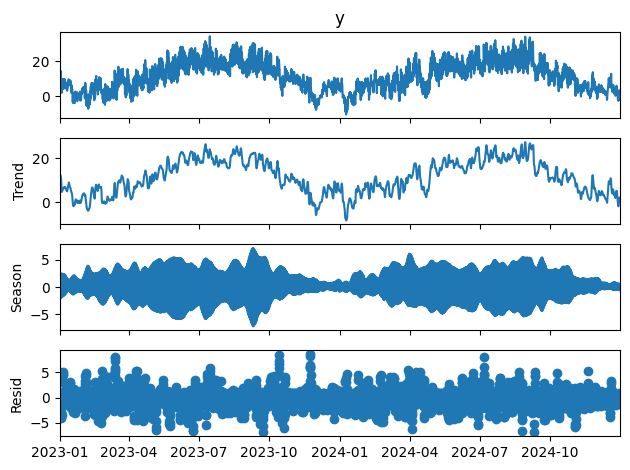

In [15]:
stl = STL(
    df_eda['y'],
    period=8,
    seasonal=13,
    robust=True
)
r_stl = stl.fit()

r_stl.plot()
plt.show()

- La tendance montre une évolution globale, avec une montée puis une descente sur la période.
- La saisonnalité est bien marquée et régulière.
- Les résidus sont centrés autour de zéro, sans motif évident, ce qui indique que la STL a bien extrait la tendance et la saisonnalité.

In [16]:
check_stationarity(r_stl.resid)


════════════════════════════════════════
📊 TEST ADF - AUGMENTED DICKEY-FULLER
════════════════════════════════════════
Hypothèse nulle (H0) : La série a une racine unitaire (non stationnaire)

Statistique ADF : -12.2704
p-value : 0.0000
Valeurs critiques :
  1%% : -3.4315
  5%% : -2.8620
  10%% : -2.5670

Conclusion ADF : Stationnaire (α=0.05)


np.True_

In [17]:
check_stationarity_kpss(r_stl.resid)


════════════════════════════════════════
📈 TEST KPSS - KWiatkowski-Phillips-Schmidt-Shin
════════════════════════════════════════
Hypothèse nulle (H0) : La série est stationnaire autour d'une constante

Statistique KPSS : 0.0598
p-value : 0.1000
Valeurs critiques :
  10%% : 0.3470
  5%% : 0.4630
  2.5%% : 0.5740
  1%% : 0.7390

Conclusion KPSS : Stationnaire (α=0.05)


np.True_

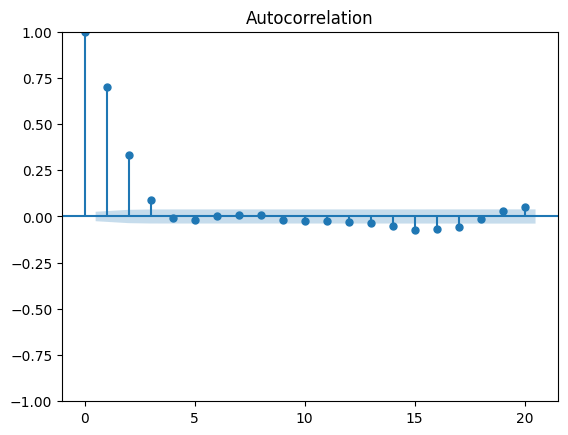

In [18]:
residus = r_stl.resid.dropna()

# Graphique ACF
plot_acf(residus, lags=20)
plt.show()

**Autocorrélation significative** : les 4 premiers lags dépassent les bandes de confiance (lignes horizontales). Cela signifie qu'il reste de la structure temporelle dans les résidus que la décomposition STL n'a pas capturée.

In [19]:
from statsmodels.stats.diagnostic import acorr_ljungbox
dernier_lag = 10

test_result = acorr_ljungbox(residus, lags=10, return_df=True)
pvalue = test_result['lb_pvalue'].iloc[-1]
print(f"Ljung-Box (lag={dernier_lag}) : p-value = {pvalue:.4f}")
if pvalue < 0.05:
    print("→ Résidus autocorrélés : le modèle n'explique pas toute la structure.")
else:
    print("→ Résidus = bruit blanc : pas d'autocorrélation détectée.")

Ljung-Box (lag=10) : p-value = 0.0000
→ Résidus autocorrélés : le modèle n'explique pas toute la structure.


Cette situation n'est pas nécessairement problématique en soi, mais représente plutôt une opportunité d'amélioration. Les résidus autocorrélés contiennent des informations prédictives précieuses qui peuvent être exploitées pour enrichir les prévisions finales.

La solution la plus recommandée consiste à adopter une approche hybride STL-ARIMA qui tire parti de la structure autocorrélative des résidus.

## 4. Préparation des Données pour ML

Approche Hybrid STL + Model

### 4.1 Nettoyage des données

In [20]:
df_eda = nan_interpolation_linear(df_eda, 'y')
df_eda = nan_interpolation_linear(df_eda, 'relative_humidity_2m')

### 4.2 Division train/validation/test

In [21]:
train_size = int(len(df_y) * 0.9)

In [22]:
df_model = df_eda.reset_index().rename(columns={'index': 'ds'}).copy()

train = df_model[:train_size]
test = df_model[train_size:]

print("DATA:", train.shape, test.shape)

DATA: (5256, 4) (585, 4)


## 5. Modélisation - Méthodes Statistiques

Les approches à ARIMA SARIMA ET SARIMAX on ete tester avec un recherche des parametre faite avec l'aide de optuna et une decoupe de dataset manuelle et et avec timesplit séries. Tout a echouer a des scores MAPE de plus de 200%

### ARIMA

Application du modèle ARIMA sur les données prétraitées, sans décomposition préalable par STL.

In [23]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 1)
        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(0, 0, 0, 0),
            trend=trend
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [25]:
arima = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(0,0,0,0),
            trend=study.best_params['trend']
        )
r_arima = arima.fit()

In [26]:
p_arima = r_arima.get_forecast(steps=len(test))

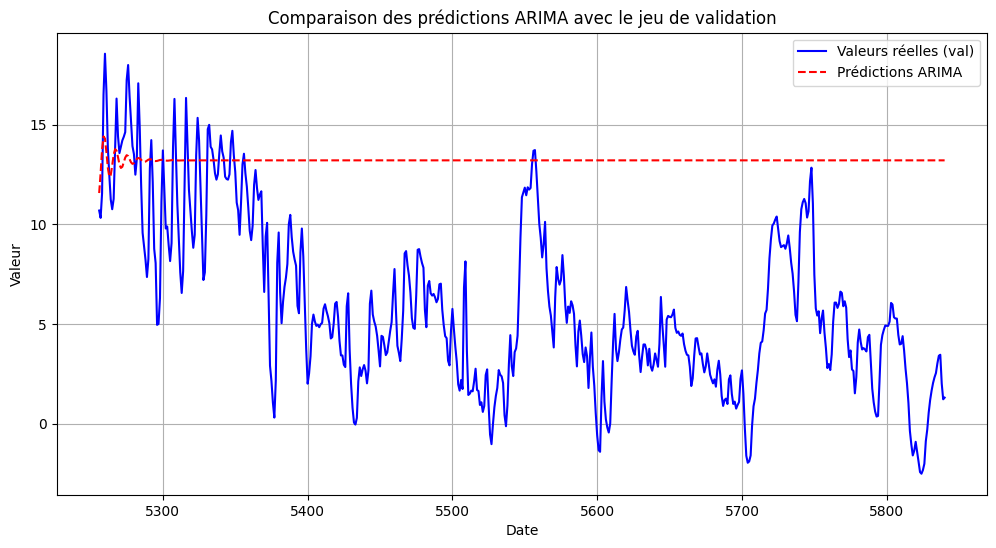

In [27]:
match_val_predict(p_arima.predicted_mean, test['y'], 'ARIMA').show()

In [28]:
m_arima = metrics_result(p_arima.predicted_mean, test['y'])

Le modèle ARIMA ne parvient pas à suivre la variabilité des valeurs réelles: il prédit une valeur quasi constante, ce qui explique les erreurs élevées observées (MAE: 7.95, RMSE: 8.86, MAPE: 881.73%).

In [29]:
logger_manager.log_training('ARIMA', study.best_value, study.best_params, m_arima)

### SARIMA

Application du modèle SARIMA sur les données prétraitées, sans décomposition préalable par STL.

In [30]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, 8),
            trend=trend
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [32]:
sarima = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(study.best_params['P'], study.best_params['D'], study.best_params['Q'], 8),
            trend=study.best_params['trend']
        )
r_sarima = sarima.fit()

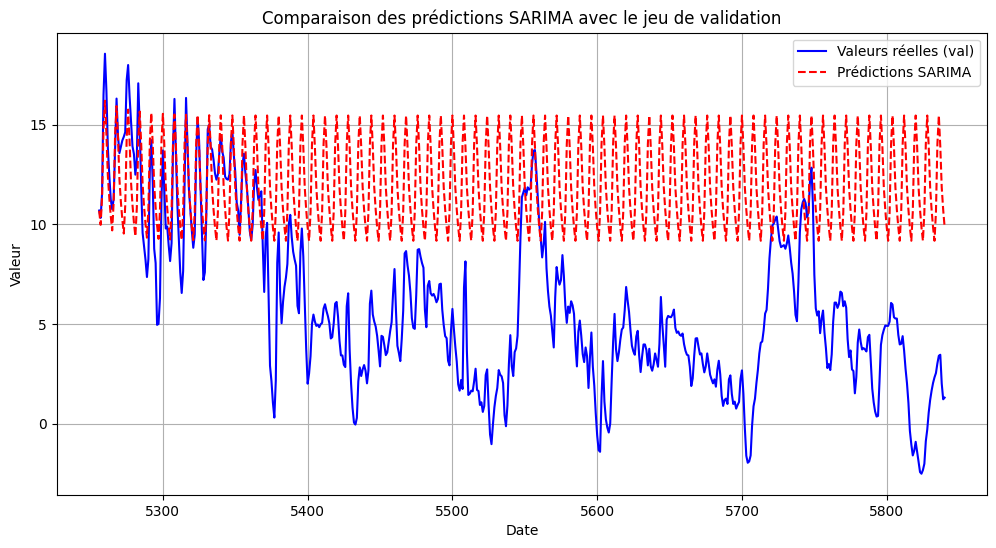

In [33]:
p_sarima = r_sarima.get_forecast(steps=len(test))

match_val_predict(p_sarima.predicted_mean, test['y'], 'SARIMA').show()

In [34]:
m_sarima = metrics_result(p_sarima.predicted_mean, test['y'])

Le modèle SARIMA ne parvient pas à suivre la variabilité des valeurs réelles : ses prédictions restent quasi constantes et ne capturent ni les fluctuations ni les tendances du jeu de validation. Cela montre que SARIMA, dans sa configuration actuelle, n’est pas adapté à la complexité ou à la forte variabilité de cette série temporelle

In [35]:
logger_manager.log_training('SARIMA', study.best_value, study.best_params, m_sarima, "notebook")

### SARIMAX

Application du modèle SARIMAX sur les données prétraitées, sans décomposition préalable par STL.

In [36]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train):
        train_tss, val_tss = train.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        P = trial.suggest_int('P', 0, 3)
        D = trial.suggest_int('D', 0, 2)
        Q = trial.suggest_int('Q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss['y'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, 8),
            trend=trend,
            exog=train_tss['relative_humidity_2m']
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [39]:
sarimax = SARIMAX(
            train['y'],
            order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
            seasonal_order=(study.best_params['P'],  study.best_params['D'], study.best_params['Q'], 8),
            trend=study.best_params['trend'],
            exog=train['relative_humidity_2m']
        )
r_sarimax = sarima.fit()

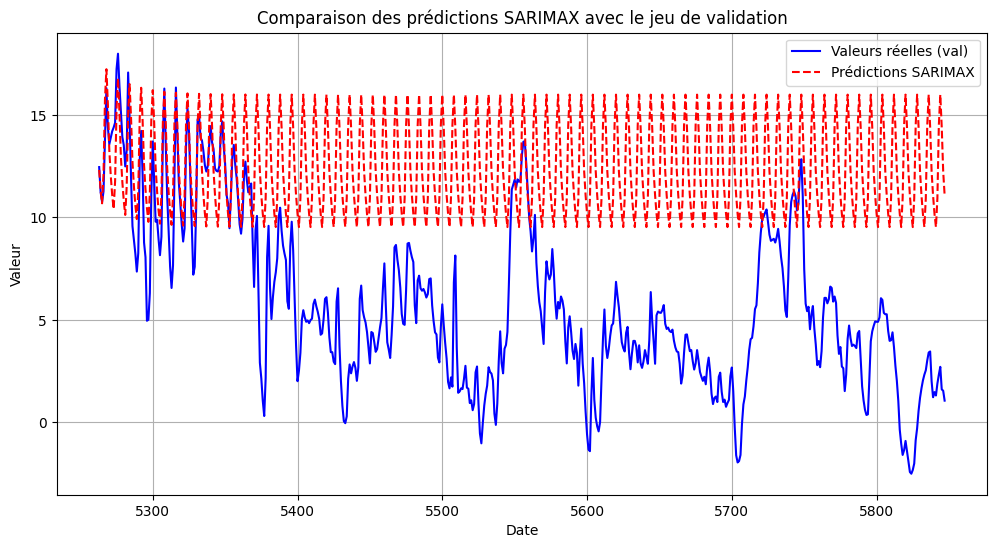

In [40]:
p_sarimax = r_sarimax.get_forecast(steps=len(test))

match_val_predict(p_sarimax.predicted_mean, test['y'], 'SARIMAX').show()

In [41]:
m_sarimax = metrics_result(p_sarimax.predicted_mean, test['y'])

MAPE : 690.0%
MAE : 6.83
RMSE : 7.84
R² : -2.558


In [42]:
logger_manager.log_training('SARIMAX', study.best_value, study.best_params, m_sarimax)

✅ Logged SARIMAX training parameters


### STL+ARIMA

Au vu des limites du modèle SARIMA à capturer la variabilité des données et des résultats des tests de diagnostic, l'approche hybride STL-ARIMA est fortement recommandée. Les tests révèlent que :

Analyse des résidus : Le test de Ljung-Box (p-value = 0.0000) confirme que les résidus sont significativement autocorrélés, indiquant que le modèle SARIMA n'explique pas toute la structure temporelle des données.

Tests de stationnarité : Avant décomposition STL, les résultats sont contradictoires (ADF stationnaire vs KPSS non-stationnaire), suggérant une stationnarité de tendance. Après décomposition STL, les deux tests concordent (ADF et KPSS stationnaires), confirmant que STL améliore efficacement les propriétés statistiques des données.

Cette concordance des tests post-STL et la persistance d'autocorrélation dans les résidus justifient l'adoption d'une approche hybride pour mieux capturer les patterns complexes de la série temporelle.

In [43]:
stl_arima_train = STL(train['y'], period=8)
r_train_stl_arima = stl_arima_train.fit()

stl_arima_test = STL(test['y'], period=8)
r_test_stl_arima = stl_arima_test.fit()

In [44]:
train_stl_arima = pd.DataFrame(r_train_stl_arima.resid)
test_stl_arima = pd.DataFrame(r_test_stl_arima.resid)

train_stl_arima = train_stl_arima.rename(columns={'resid': 'y'})
test_stl_arima = test_stl_arima.rename(columns={'resid': 'y'})


In [45]:
def objective(trial):
    aic_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    for train_idx, val_idx in tscv.split(train_stl_arima):
        train_tss, val_tss = train_stl_arima.iloc[train_idx], train.iloc[val_idx]

        p = trial.suggest_int('p', 0, 3)
        d = trial.suggest_int('d', 0, 2)
        q = trial.suggest_int('q', 0, 2)

        trend = trial.suggest_categorical('trend', ['n', 'c', 't'])

        model = SARIMAX(
            train_tss,
            order=(p, d, q),
            seasonal_order=(0, 0, 0, 0),
            trend=trend,
        )

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            results = model.fit(disp=False)

        aic_scores.append(results.aic)

    return np.mean(aic_scores)

In [46]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

In [47]:
stl_arima = SARIMAX(
    train_stl_arima,
    order=(study.best_params['p'], study.best_params['d'], study.best_params['q']),
    seasonal_order=(0, 0, 0, 0),
    trend=study.best_params['trend']
)
r_stl_arima = stl_arima.fit()


C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
p_stl_arima = r_stl_arima.get_forecast(steps=len(test))

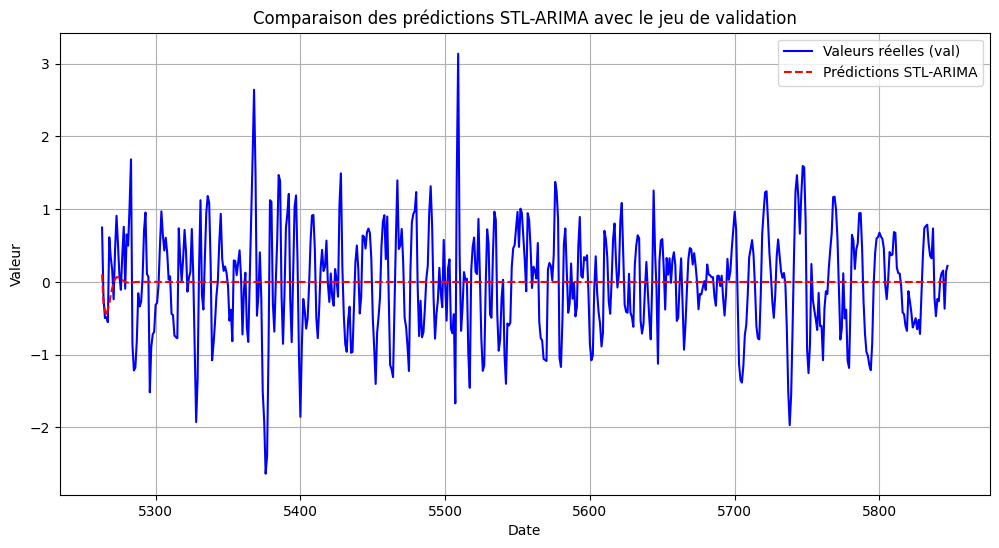

In [49]:
match_val_predict(p_stl_arima.predicted_mean, test_stl_arima['y'], 'STL-ARIMA').show()

In [50]:
m_stl_arima = metrics_result(p_stl_arima.predicted_mean, test_stl_arima['y'])

MAPE : 99.6%
MAE : 0.56
RMSE : 0.71
R² : 0.002


Le modèle STL-ARIMA s'avère inadapté pour cette série temporelle.
Les métriques catastrophiques (MAPE 99.6%, R² ≈ 0) confirment
l'échec total du modèle à capturer les dynamiques temporelles.

→ Justification solide pour passer aux méthodes ML (XGBoost/LSTM)
→ Baseline de comparaison établie (tout modèle > 0.002 R² sera meilleur)

In [51]:
logger_manager.log_training('STL-ARIMA', study.best_value, study.best_params, m_stl_arima)

✅ Logged STL-ARIMA training parameters


## 6. Modélisation - Machine Learning

In [23]:
df_ml_model = df_eda.reset_index().rename(columns={'index': 'ds'}).copy()

df_ml_model.drop('unique_id', axis=1, inplace=True)

train_ml = df_ml_model[:train_size].copy()
test_ml = df_ml_model[train_size:].copy()

train_ml_without_exog = train_ml.drop('relative_humidity_2m', axis=1).copy()
test_ml_without_exog = test_ml.drop('relative_humidity_2m', axis=1).copy()

print("DATA:", train.shape, test.shape)

DATA: (5256, 4) (585, 4)


### XGBoost

In [30]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Paramètres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Paramètres XGBoost
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_depth = trial.suggest_int('max_depth', 4, 6)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    subsample = trial.suggest_float('subsample', 0.7, 0.9)

    train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Créer les lag features
        lag_transformer = LagFeatures(
            variables= ['y'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y'])
        y_val = val_transformed['y']

        # Entraînement
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42,
            eval_metric='rmse',
            early_stopping_rounds=10,
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
        )

        # Prédiction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)


In [31]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

[0]	validation_0-rmse:10.07570
[1]	validation_0-rmse:9.60557
[2]	validation_0-rmse:9.13553
[3]	validation_0-rmse:8.70644
[4]	validation_0-rmse:8.28682
[5]	validation_0-rmse:7.90074
[6]	validation_0-rmse:7.53199
[7]	validation_0-rmse:7.19112
[8]	validation_0-rmse:6.84659
[9]	validation_0-rmse:6.53917
[10]	validation_0-rmse:6.25559
[11]	validation_0-rmse:5.98310
[12]	validation_0-rmse:5.71326
[13]	validation_0-rmse:5.47190
[14]	validation_0-rmse:5.24260
[15]	validation_0-rmse:5.03140
[16]	validation_0-rmse:4.81658
[17]	validation_0-rmse:4.62751
[18]	validation_0-rmse:4.44954
[19]	validation_0-rmse:4.28018
[20]	validation_0-rmse:4.12111
[21]	validation_0-rmse:3.98173
[22]	validation_0-rmse:3.84840
[23]	validation_0-rmse:3.73273
[24]	validation_0-rmse:3.61940
[25]	validation_0-rmse:3.50291
[26]	validation_0-rmse:3.41118
[27]	validation_0-rmse:3.30765
[28]	validation_0-rmse:3.20996
[29]	validation_0-rmse:3.11620
[30]	validation_0-rmse:3.03660
[31]	validation_0-rmse:2.95194
[32]	validation_0

Best trial: 0. Best value: 2.75658:   1%|          | 1/100 [00:01<03:00,  1.82s/it]

[0]	validation_0-rmse:10.10771
[1]	validation_0-rmse:9.65792
[2]	validation_0-rmse:9.22634
[3]	validation_0-rmse:8.81465
[4]	validation_0-rmse:8.42705
[5]	validation_0-rmse:8.05295
[6]	validation_0-rmse:7.70990
[7]	validation_0-rmse:7.36675
[8]	validation_0-rmse:7.04875
[9]	validation_0-rmse:6.75387
[10]	validation_0-rmse:6.47046
[11]	validation_0-rmse:6.19953
[12]	validation_0-rmse:5.92527
[13]	validation_0-rmse:5.67182
[14]	validation_0-rmse:5.46582
[15]	validation_0-rmse:5.25515
[16]	validation_0-rmse:5.03083
[17]	validation_0-rmse:4.84557
[18]	validation_0-rmse:4.66058
[19]	validation_0-rmse:4.50268
[20]	validation_0-rmse:4.34285
[21]	validation_0-rmse:4.18445
[22]	validation_0-rmse:4.03990
[23]	validation_0-rmse:3.91766
[24]	validation_0-rmse:3.79104
[25]	validation_0-rmse:3.67860
[26]	validation_0-rmse:3.57156
[27]	validation_0-rmse:3.46056
[28]	validation_0-rmse:3.36082
[29]	validation_0-rmse:3.26807
[30]	validation_0-rmse:3.18394
[31]	validation_0-rmse:3.09751
[32]	validation_0

Best trial: 0. Best value: 2.75658:   2%|▏         | 2/100 [00:03<02:31,  1.54s/it]

[0]	validation_0-rmse:9.86379
[1]	validation_0-rmse:9.16165
[2]	validation_0-rmse:8.52356
[3]	validation_0-rmse:7.93312
[4]	validation_0-rmse:7.41354
[5]	validation_0-rmse:6.92034
[6]	validation_0-rmse:6.44598
[7]	validation_0-rmse:6.04567
[8]	validation_0-rmse:5.62172
[9]	validation_0-rmse:5.30367
[10]	validation_0-rmse:4.95256
[11]	validation_0-rmse:4.65524
[12]	validation_0-rmse:4.36847
[13]	validation_0-rmse:4.11648
[14]	validation_0-rmse:3.89908
[15]	validation_0-rmse:3.68642
[16]	validation_0-rmse:3.49374
[17]	validation_0-rmse:3.30907
[18]	validation_0-rmse:3.15549
[19]	validation_0-rmse:3.00690
[20]	validation_0-rmse:2.88558
[21]	validation_0-rmse:2.76752
[22]	validation_0-rmse:2.66391
[23]	validation_0-rmse:2.56847
[24]	validation_0-rmse:2.46927
[25]	validation_0-rmse:2.38685
[26]	validation_0-rmse:2.30233
[27]	validation_0-rmse:2.24624
[28]	validation_0-rmse:2.19339
[29]	validation_0-rmse:2.15373
[30]	validation_0-rmse:2.09708
[31]	validation_0-rmse:2.05022
[32]	validation_0-

Best trial: 2. Best value: 1.85614:   3%|▎         | 3/100 [00:04<02:27,  1.52s/it]

[0]	validation_0-rmse:9.70171
[1]	validation_0-rmse:8.86317
[2]	validation_0-rmse:8.13651
[3]	validation_0-rmse:7.46704
[4]	validation_0-rmse:6.85892
[5]	validation_0-rmse:6.32230
[6]	validation_0-rmse:5.81856
[7]	validation_0-rmse:5.37724
[8]	validation_0-rmse:4.96638
[9]	validation_0-rmse:4.59861
[10]	validation_0-rmse:4.27618
[11]	validation_0-rmse:3.97613
[12]	validation_0-rmse:3.71805
[13]	validation_0-rmse:3.47551
[14]	validation_0-rmse:3.26165
[15]	validation_0-rmse:3.06648
[16]	validation_0-rmse:2.90033
[17]	validation_0-rmse:2.74458
[18]	validation_0-rmse:2.63409
[19]	validation_0-rmse:2.51870
[20]	validation_0-rmse:2.41324
[21]	validation_0-rmse:2.32446
[22]	validation_0-rmse:2.25147
[23]	validation_0-rmse:2.17900
[24]	validation_0-rmse:2.11539
[25]	validation_0-rmse:2.06985
[26]	validation_0-rmse:2.01941
[27]	validation_0-rmse:1.97187
[28]	validation_0-rmse:1.93371
[29]	validation_0-rmse:1.89663
[30]	validation_0-rmse:1.86934
[31]	validation_0-rmse:1.84929
[32]	validation_0-

Best trial: 2. Best value: 1.85614:   4%|▍         | 4/100 [00:06<02:19,  1.46s/it]

[0]	validation_0-rmse:10.07181
[1]	validation_0-rmse:9.56350
[2]	validation_0-rmse:9.08420
[3]	validation_0-rmse:8.62666
[4]	validation_0-rmse:8.20494
[5]	validation_0-rmse:7.79315
[6]	validation_0-rmse:7.40878
[7]	validation_0-rmse:7.05539
[8]	validation_0-rmse:6.71386
[9]	validation_0-rmse:6.38876
[10]	validation_0-rmse:6.09137
[11]	validation_0-rmse:5.82246
[12]	validation_0-rmse:5.54068
[13]	validation_0-rmse:5.29159
[14]	validation_0-rmse:5.04937
[15]	validation_0-rmse:4.81740
[16]	validation_0-rmse:4.60150
[17]	validation_0-rmse:4.39895
[18]	validation_0-rmse:4.20965
[19]	validation_0-rmse:4.03443
[20]	validation_0-rmse:3.87332
[21]	validation_0-rmse:3.72541
[22]	validation_0-rmse:3.58504
[23]	validation_0-rmse:3.44672
[24]	validation_0-rmse:3.32410
[25]	validation_0-rmse:3.20520
[26]	validation_0-rmse:3.09405
[27]	validation_0-rmse:2.99266
[28]	validation_0-rmse:2.89673
[29]	validation_0-rmse:2.80846
[30]	validation_0-rmse:2.71897
[31]	validation_0-rmse:2.65179
[32]	validation_0

Best trial: 2. Best value: 1.85614:   5%|▌         | 5/100 [00:08<02:42,  1.71s/it]

[0]	validation_0-rmse:9.76156
[1]	validation_0-rmse:8.99246
[2]	validation_0-rmse:8.31993
[3]	validation_0-rmse:7.70706
[4]	validation_0-rmse:7.16257
[5]	validation_0-rmse:6.65090
[6]	validation_0-rmse:6.20427
[7]	validation_0-rmse:5.79003
[8]	validation_0-rmse:5.41368
[9]	validation_0-rmse:5.06119
[10]	validation_0-rmse:4.75881
[11]	validation_0-rmse:4.49701
[12]	validation_0-rmse:4.24924
[13]	validation_0-rmse:4.03661
[14]	validation_0-rmse:3.85775
[15]	validation_0-rmse:3.68954
[16]	validation_0-rmse:3.53114
[17]	validation_0-rmse:3.39443
[18]	validation_0-rmse:3.28053
[19]	validation_0-rmse:3.18043
[20]	validation_0-rmse:3.09348
[21]	validation_0-rmse:3.02832
[22]	validation_0-rmse:2.96020
[23]	validation_0-rmse:2.89944
[24]	validation_0-rmse:2.84675
[25]	validation_0-rmse:2.80492
[26]	validation_0-rmse:2.75902
[27]	validation_0-rmse:2.72893
[28]	validation_0-rmse:2.70515
[29]	validation_0-rmse:2.67250
[30]	validation_0-rmse:2.64678
[31]	validation_0-rmse:2.62840
[32]	validation_0-

Best trial: 2. Best value: 1.85614:   6%|▌         | 6/100 [00:08<02:08,  1.37s/it]

[0]	validation_0-rmse:9.84495
[1]	validation_0-rmse:9.19098
[2]	validation_0-rmse:8.59784
[3]	validation_0-rmse:8.03484
[4]	validation_0-rmse:7.52760
[5]	validation_0-rmse:7.06977
[6]	validation_0-rmse:6.66758
[7]	validation_0-rmse:6.28570
[8]	validation_0-rmse:5.92992
[9]	validation_0-rmse:5.59404
[10]	validation_0-rmse:5.30271
[11]	validation_0-rmse:5.02078
[12]	validation_0-rmse:4.78011
[13]	validation_0-rmse:4.56180
[14]	validation_0-rmse:4.36083
[15]	validation_0-rmse:4.16258
[16]	validation_0-rmse:3.99817
[17]	validation_0-rmse:3.83881
[18]	validation_0-rmse:3.69133
[19]	validation_0-rmse:3.56063
[20]	validation_0-rmse:3.44764
[21]	validation_0-rmse:3.33894
[22]	validation_0-rmse:3.23625
[23]	validation_0-rmse:3.16033
[24]	validation_0-rmse:3.08247
[25]	validation_0-rmse:3.01098
[26]	validation_0-rmse:2.94344
[27]	validation_0-rmse:2.88880
[28]	validation_0-rmse:2.82978
[29]	validation_0-rmse:2.78114
[30]	validation_0-rmse:2.71971
[31]	validation_0-rmse:2.68474
[32]	validation_0-

Best trial: 2. Best value: 1.85614:   7%|▋         | 7/100 [00:10<02:18,  1.49s/it]

[0]	validation_0-rmse:9.94654
[1]	validation_0-rmse:9.33707
[2]	validation_0-rmse:8.76250
[3]	validation_0-rmse:8.25721
[4]	validation_0-rmse:7.78252
[5]	validation_0-rmse:7.33267
[6]	validation_0-rmse:6.91238
[7]	validation_0-rmse:6.54501
[8]	validation_0-rmse:6.21271
[9]	validation_0-rmse:5.87824
[10]	validation_0-rmse:5.58088
[11]	validation_0-rmse:5.32545
[12]	validation_0-rmse:5.08223
[13]	validation_0-rmse:4.86747
[14]	validation_0-rmse:4.65620
[15]	validation_0-rmse:4.47560
[16]	validation_0-rmse:4.30011
[17]	validation_0-rmse:4.14042
[18]	validation_0-rmse:3.99796
[19]	validation_0-rmse:3.85872
[20]	validation_0-rmse:3.71966
[21]	validation_0-rmse:3.60424
[22]	validation_0-rmse:3.50282
[23]	validation_0-rmse:3.41725
[24]	validation_0-rmse:3.32759
[25]	validation_0-rmse:3.24268
[26]	validation_0-rmse:3.16711
[27]	validation_0-rmse:3.10248
[28]	validation_0-rmse:3.04727
[29]	validation_0-rmse:2.99039
[30]	validation_0-rmse:2.93298
[31]	validation_0-rmse:2.88122
[32]	validation_0-

Best trial: 2. Best value: 1.85614:   8%|▊         | 8/100 [00:12<02:23,  1.56s/it]

[0]	validation_0-rmse:9.94769
[1]	validation_0-rmse:9.36067
[2]	validation_0-rmse:8.79570
[3]	validation_0-rmse:8.26954
[4]	validation_0-rmse:7.78705
[5]	validation_0-rmse:7.33614
[6]	validation_0-rmse:6.94615
[7]	validation_0-rmse:6.58779
[8]	validation_0-rmse:6.26103
[9]	validation_0-rmse:5.93631
[10]	validation_0-rmse:5.65813
[11]	validation_0-rmse:5.37788
[12]	validation_0-rmse:5.11864
[13]	validation_0-rmse:4.87844
[14]	validation_0-rmse:4.67309
[15]	validation_0-rmse:4.47493
[16]	validation_0-rmse:4.26214
[17]	validation_0-rmse:4.08674
[18]	validation_0-rmse:3.92436
[19]	validation_0-rmse:3.76763
[20]	validation_0-rmse:3.62687
[21]	validation_0-rmse:3.51527
[22]	validation_0-rmse:3.39386
[23]	validation_0-rmse:3.29377
[24]	validation_0-rmse:3.20579
[25]	validation_0-rmse:3.12423
[26]	validation_0-rmse:3.03805
[27]	validation_0-rmse:2.97054
[28]	validation_0-rmse:2.90357
[29]	validation_0-rmse:2.84410
[30]	validation_0-rmse:2.78077
[31]	validation_0-rmse:2.72425
[32]	validation_0-

Best trial: 2. Best value: 1.85614:   9%|▉         | 9/100 [00:13<02:20,  1.54s/it]

[0]	validation_0-rmse:9.93891
[1]	validation_0-rmse:9.31269
[2]	validation_0-rmse:8.73658
[3]	validation_0-rmse:8.18741
[4]	validation_0-rmse:7.67447
[5]	validation_0-rmse:7.21278
[6]	validation_0-rmse:6.79008
[7]	validation_0-rmse:6.38849
[8]	validation_0-rmse:5.99424
[9]	validation_0-rmse:5.63006
[10]	validation_0-rmse:5.30835
[11]	validation_0-rmse:5.01211
[12]	validation_0-rmse:4.72735
[13]	validation_0-rmse:4.47845
[14]	validation_0-rmse:4.24394
[15]	validation_0-rmse:4.03311
[16]	validation_0-rmse:3.84254
[17]	validation_0-rmse:3.64494
[18]	validation_0-rmse:3.47149
[19]	validation_0-rmse:3.32171
[20]	validation_0-rmse:3.18137
[21]	validation_0-rmse:3.05328
[22]	validation_0-rmse:2.93492
[23]	validation_0-rmse:2.82551
[24]	validation_0-rmse:2.72919
[25]	validation_0-rmse:2.63817
[26]	validation_0-rmse:2.55880
[27]	validation_0-rmse:2.48668
[28]	validation_0-rmse:2.42540
[29]	validation_0-rmse:2.35743
[30]	validation_0-rmse:2.29393
[31]	validation_0-rmse:2.23871
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  10%|█         | 10/100 [00:15<02:13,  1.49s/it]

[0]	validation_0-rmse:9.81448
[1]	validation_0-rmse:9.09497
[2]	validation_0-rmse:8.45454
[3]	validation_0-rmse:7.84750
[4]	validation_0-rmse:7.30088
[5]	validation_0-rmse:6.80370
[6]	validation_0-rmse:6.34194
[7]	validation_0-rmse:5.90669
[8]	validation_0-rmse:5.48562
[9]	validation_0-rmse:5.12895
[10]	validation_0-rmse:4.80659
[11]	validation_0-rmse:4.48541
[12]	validation_0-rmse:4.20881
[13]	validation_0-rmse:3.96078
[14]	validation_0-rmse:3.73651
[15]	validation_0-rmse:3.53659
[16]	validation_0-rmse:3.35676
[17]	validation_0-rmse:3.19249
[18]	validation_0-rmse:3.05669
[19]	validation_0-rmse:2.92024
[20]	validation_0-rmse:2.79337
[21]	validation_0-rmse:2.68996
[22]	validation_0-rmse:2.59516
[23]	validation_0-rmse:2.51105
[24]	validation_0-rmse:2.42572
[25]	validation_0-rmse:2.35889
[26]	validation_0-rmse:2.28538
[27]	validation_0-rmse:2.23245
[28]	validation_0-rmse:2.17727
[29]	validation_0-rmse:2.12841
[30]	validation_0-rmse:2.08980
[31]	validation_0-rmse:2.05643
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  11%|█         | 11/100 [00:17<02:23,  1.61s/it]

[0]	validation_0-rmse:9.98423
[1]	validation_0-rmse:9.41582
[2]	validation_0-rmse:8.88345
[3]	validation_0-rmse:8.38898
[4]	validation_0-rmse:7.91362
[5]	validation_0-rmse:7.49217
[6]	validation_0-rmse:7.08534
[7]	validation_0-rmse:6.69705
[8]	validation_0-rmse:6.32522
[9]	validation_0-rmse:5.99259
[10]	validation_0-rmse:5.67841
[11]	validation_0-rmse:5.38472
[12]	validation_0-rmse:5.11072
[13]	validation_0-rmse:4.86006
[14]	validation_0-rmse:4.62012
[15]	validation_0-rmse:4.39383
[16]	validation_0-rmse:4.19051
[17]	validation_0-rmse:3.98719
[18]	validation_0-rmse:3.80140
[19]	validation_0-rmse:3.62038
[20]	validation_0-rmse:3.46071
[21]	validation_0-rmse:3.31757
[22]	validation_0-rmse:3.18582
[23]	validation_0-rmse:3.06737
[24]	validation_0-rmse:2.95194
[25]	validation_0-rmse:2.84794
[26]	validation_0-rmse:2.74821
[27]	validation_0-rmse:2.65715
[28]	validation_0-rmse:2.58114
[29]	validation_0-rmse:2.50400
[30]	validation_0-rmse:2.44399
[31]	validation_0-rmse:2.38758
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  12%|█▏        | 12/100 [00:19<02:47,  1.91s/it]

[0]	validation_0-rmse:9.99855
[1]	validation_0-rmse:9.43544
[2]	validation_0-rmse:8.92215
[3]	validation_0-rmse:8.44499
[4]	validation_0-rmse:7.98859
[5]	validation_0-rmse:7.56523
[6]	validation_0-rmse:7.16625
[7]	validation_0-rmse:6.78066
[8]	validation_0-rmse:6.40842
[9]	validation_0-rmse:6.07958
[10]	validation_0-rmse:5.76659
[11]	validation_0-rmse:5.47310
[12]	validation_0-rmse:5.19697
[13]	validation_0-rmse:4.95272
[14]	validation_0-rmse:4.72193
[15]	validation_0-rmse:4.49579
[16]	validation_0-rmse:4.28420
[17]	validation_0-rmse:4.08366
[18]	validation_0-rmse:3.89692
[19]	validation_0-rmse:3.72002
[20]	validation_0-rmse:3.56207
[21]	validation_0-rmse:3.42004
[22]	validation_0-rmse:3.28409
[23]	validation_0-rmse:3.16061
[24]	validation_0-rmse:3.04367
[25]	validation_0-rmse:2.93382
[26]	validation_0-rmse:2.83362
[27]	validation_0-rmse:2.74328
[28]	validation_0-rmse:2.66359
[29]	validation_0-rmse:2.59006
[30]	validation_0-rmse:2.52781
[31]	validation_0-rmse:2.46500
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  13%|█▎        | 13/100 [00:21<02:51,  1.97s/it]

[0]	validation_0-rmse:9.80500
[1]	validation_0-rmse:9.08117
[2]	validation_0-rmse:8.42312
[3]	validation_0-rmse:7.81265
[4]	validation_0-rmse:7.27873
[5]	validation_0-rmse:6.76764
[6]	validation_0-rmse:6.29162
[7]	validation_0-rmse:5.87397
[8]	validation_0-rmse:5.45148
[9]	validation_0-rmse:5.10506
[10]	validation_0-rmse:4.79989
[11]	validation_0-rmse:4.49881
[12]	validation_0-rmse:4.21130
[13]	validation_0-rmse:3.96547
[14]	validation_0-rmse:3.72549
[15]	validation_0-rmse:3.50426
[16]	validation_0-rmse:3.31930
[17]	validation_0-rmse:3.14535
[18]	validation_0-rmse:2.99612
[19]	validation_0-rmse:2.85839
[20]	validation_0-rmse:2.74400
[21]	validation_0-rmse:2.64218
[22]	validation_0-rmse:2.54663
[23]	validation_0-rmse:2.46185
[24]	validation_0-rmse:2.38060
[25]	validation_0-rmse:2.31333
[26]	validation_0-rmse:2.25317
[27]	validation_0-rmse:2.20646
[28]	validation_0-rmse:2.16714
[29]	validation_0-rmse:2.13200
[30]	validation_0-rmse:2.09631
[31]	validation_0-rmse:2.06437
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  14%|█▍        | 14/100 [00:23<02:44,  1.91s/it]

[0]	validation_0-rmse:10.11968
[1]	validation_0-rmse:9.65875
[2]	validation_0-rmse:9.21700
[3]	validation_0-rmse:8.79445
[4]	validation_0-rmse:8.39021
[5]	validation_0-rmse:8.02964
[6]	validation_0-rmse:7.66820
[7]	validation_0-rmse:7.34126
[8]	validation_0-rmse:7.01460
[9]	validation_0-rmse:6.69572
[10]	validation_0-rmse:6.41807
[11]	validation_0-rmse:6.13842
[12]	validation_0-rmse:5.87991
[13]	validation_0-rmse:5.63845
[14]	validation_0-rmse:5.41682
[15]	validation_0-rmse:5.21269
[16]	validation_0-rmse:5.00194
[17]	validation_0-rmse:4.79984
[18]	validation_0-rmse:4.60757
[19]	validation_0-rmse:4.42815
[20]	validation_0-rmse:4.25453
[21]	validation_0-rmse:4.09282
[22]	validation_0-rmse:3.95671
[23]	validation_0-rmse:3.80458
[24]	validation_0-rmse:3.67199
[25]	validation_0-rmse:3.54595
[26]	validation_0-rmse:3.41478
[27]	validation_0-rmse:3.30491
[28]	validation_0-rmse:3.20190
[29]	validation_0-rmse:3.10367
[30]	validation_0-rmse:3.01223
[31]	validation_0-rmse:2.93214
[32]	validation_0

Best trial: 2. Best value: 1.85614:  15%|█▌        | 15/100 [00:26<02:56,  2.08s/it]

[0]	validation_0-rmse:9.77574
[1]	validation_0-rmse:9.02400
[2]	validation_0-rmse:8.35765
[3]	validation_0-rmse:7.72926
[4]	validation_0-rmse:7.16540
[5]	validation_0-rmse:6.63433
[6]	validation_0-rmse:6.16304
[7]	validation_0-rmse:5.72165
[8]	validation_0-rmse:5.29706
[9]	validation_0-rmse:4.93891
[10]	validation_0-rmse:4.61664
[11]	validation_0-rmse:4.31135
[12]	validation_0-rmse:4.04811
[13]	validation_0-rmse:3.80056
[14]	validation_0-rmse:3.58079
[15]	validation_0-rmse:3.38114
[16]	validation_0-rmse:3.19396
[17]	validation_0-rmse:3.02908
[18]	validation_0-rmse:2.88549
[19]	validation_0-rmse:2.75869
[20]	validation_0-rmse:2.63631
[21]	validation_0-rmse:2.53935
[22]	validation_0-rmse:2.45314
[23]	validation_0-rmse:2.37171
[24]	validation_0-rmse:2.29591
[25]	validation_0-rmse:2.23625
[26]	validation_0-rmse:2.17325
[27]	validation_0-rmse:2.12875
[28]	validation_0-rmse:2.07164
[29]	validation_0-rmse:2.03028
[30]	validation_0-rmse:1.99467
[31]	validation_0-rmse:1.96781
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  16%|█▌        | 16/100 [00:28<02:58,  2.12s/it]

[0]	validation_0-rmse:10.00188
[1]	validation_0-rmse:9.44274
[2]	validation_0-rmse:8.89256
[3]	validation_0-rmse:8.39161
[4]	validation_0-rmse:7.91976
[5]	validation_0-rmse:7.47509
[6]	validation_0-rmse:7.06578
[7]	validation_0-rmse:6.67833
[8]	validation_0-rmse:6.31255
[9]	validation_0-rmse:5.95046
[10]	validation_0-rmse:5.65461
[11]	validation_0-rmse:5.36453
[12]	validation_0-rmse:5.09343
[13]	validation_0-rmse:4.84217
[14]	validation_0-rmse:4.60105
[15]	validation_0-rmse:4.39731
[16]	validation_0-rmse:4.20362
[17]	validation_0-rmse:4.01502
[18]	validation_0-rmse:3.83342
[19]	validation_0-rmse:3.66876
[20]	validation_0-rmse:3.51373
[21]	validation_0-rmse:3.38123
[22]	validation_0-rmse:3.26232
[23]	validation_0-rmse:3.14800
[24]	validation_0-rmse:3.04143
[25]	validation_0-rmse:2.93369
[26]	validation_0-rmse:2.83644
[27]	validation_0-rmse:2.74369
[28]	validation_0-rmse:2.66786
[29]	validation_0-rmse:2.58863
[30]	validation_0-rmse:2.51836
[31]	validation_0-rmse:2.45417
[32]	validation_0

Best trial: 2. Best value: 1.85614:  17%|█▋        | 17/100 [00:29<02:30,  1.81s/it]

[0]	validation_0-rmse:9.65423
[1]	validation_0-rmse:8.78871
[2]	validation_0-rmse:8.01618
[3]	validation_0-rmse:7.33621
[4]	validation_0-rmse:6.72175
[5]	validation_0-rmse:6.15053
[6]	validation_0-rmse:5.65679
[7]	validation_0-rmse:5.23507
[8]	validation_0-rmse:4.80758
[9]	validation_0-rmse:4.43497
[10]	validation_0-rmse:4.12539
[11]	validation_0-rmse:3.82072
[12]	validation_0-rmse:3.56734
[13]	validation_0-rmse:3.32708
[14]	validation_0-rmse:3.11495
[15]	validation_0-rmse:2.92548
[16]	validation_0-rmse:2.75647
[17]	validation_0-rmse:2.61361
[18]	validation_0-rmse:2.48240
[19]	validation_0-rmse:2.36121
[20]	validation_0-rmse:2.27581
[21]	validation_0-rmse:2.18872
[22]	validation_0-rmse:2.12838
[23]	validation_0-rmse:2.06815
[24]	validation_0-rmse:2.01570
[25]	validation_0-rmse:1.95752
[26]	validation_0-rmse:1.90954
[27]	validation_0-rmse:1.88319
[28]	validation_0-rmse:1.85737
[29]	validation_0-rmse:1.83064
[30]	validation_0-rmse:1.80201
[31]	validation_0-rmse:1.78547
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  18%|█▊        | 18/100 [00:30<02:23,  1.76s/it]

[0]	validation_0-rmse:9.88767
[1]	validation_0-rmse:9.20487
[2]	validation_0-rmse:8.59176
[3]	validation_0-rmse:8.02440
[4]	validation_0-rmse:7.49359
[5]	validation_0-rmse:7.01208
[6]	validation_0-rmse:6.55494
[7]	validation_0-rmse:6.15404
[8]	validation_0-rmse:5.75748
[9]	validation_0-rmse:5.42861
[10]	validation_0-rmse:5.10670
[11]	validation_0-rmse:4.81312
[12]	validation_0-rmse:4.52061
[13]	validation_0-rmse:4.26862
[14]	validation_0-rmse:4.03796
[15]	validation_0-rmse:3.83238
[16]	validation_0-rmse:3.64608
[17]	validation_0-rmse:3.49026
[18]	validation_0-rmse:3.32140
[19]	validation_0-rmse:3.17858
[20]	validation_0-rmse:3.04120
[21]	validation_0-rmse:2.92808
[22]	validation_0-rmse:2.82448
[23]	validation_0-rmse:2.73418
[24]	validation_0-rmse:2.64349
[25]	validation_0-rmse:2.57448
[26]	validation_0-rmse:2.50633
[27]	validation_0-rmse:2.44073
[28]	validation_0-rmse:2.36905
[29]	validation_0-rmse:2.31351
[30]	validation_0-rmse:2.25862
[31]	validation_0-rmse:2.22090
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  19%|█▉        | 19/100 [00:32<02:14,  1.66s/it]

[0]	validation_0-rmse:9.95182
[1]	validation_0-rmse:9.33829
[2]	validation_0-rmse:8.77478
[3]	validation_0-rmse:8.24536
[4]	validation_0-rmse:7.78848
[5]	validation_0-rmse:7.33441
[6]	validation_0-rmse:6.91046
[7]	validation_0-rmse:6.53220
[8]	validation_0-rmse:6.15770
[9]	validation_0-rmse:5.82276
[10]	validation_0-rmse:5.49354
[11]	validation_0-rmse:5.18798
[12]	validation_0-rmse:4.91779
[13]	validation_0-rmse:4.66106
[14]	validation_0-rmse:4.42462
[15]	validation_0-rmse:4.20816
[16]	validation_0-rmse:3.98728
[17]	validation_0-rmse:3.78692
[18]	validation_0-rmse:3.60464
[19]	validation_0-rmse:3.44306
[20]	validation_0-rmse:3.28469
[21]	validation_0-rmse:3.14772
[22]	validation_0-rmse:3.01898
[23]	validation_0-rmse:2.90047
[24]	validation_0-rmse:2.78595
[25]	validation_0-rmse:2.69018
[26]	validation_0-rmse:2.58848
[27]	validation_0-rmse:2.51342
[28]	validation_0-rmse:2.43689
[29]	validation_0-rmse:2.36955
[30]	validation_0-rmse:2.30073
[31]	validation_0-rmse:2.25372
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  20%|██        | 20/100 [00:34<02:27,  1.84s/it]

[0]	validation_0-rmse:9.94331
[1]	validation_0-rmse:9.34251
[2]	validation_0-rmse:8.79005
[3]	validation_0-rmse:8.24249
[4]	validation_0-rmse:7.75697
[5]	validation_0-rmse:7.29387
[6]	validation_0-rmse:6.88149
[7]	validation_0-rmse:6.47783
[8]	validation_0-rmse:6.10702
[9]	validation_0-rmse:5.76969
[10]	validation_0-rmse:5.47247
[11]	validation_0-rmse:5.17397
[12]	validation_0-rmse:4.86239
[13]	validation_0-rmse:4.61654
[14]	validation_0-rmse:4.38317
[15]	validation_0-rmse:4.16794
[16]	validation_0-rmse:3.94652
[17]	validation_0-rmse:3.75926
[18]	validation_0-rmse:3.57278
[19]	validation_0-rmse:3.40799
[20]	validation_0-rmse:3.24566
[21]	validation_0-rmse:3.11588
[22]	validation_0-rmse:2.99335
[23]	validation_0-rmse:2.87378
[24]	validation_0-rmse:2.78245
[25]	validation_0-rmse:2.68451
[26]	validation_0-rmse:2.59730
[27]	validation_0-rmse:2.52843
[28]	validation_0-rmse:2.45809
[29]	validation_0-rmse:2.39353
[30]	validation_0-rmse:2.33146
[31]	validation_0-rmse:2.28094
[32]	validation_0-

Best trial: 2. Best value: 1.85614:  21%|██        | 21/100 [00:36<02:21,  1.79s/it]

[0]	validation_0-rmse:10.11509
[1]	validation_0-rmse:9.64876
[2]	validation_0-rmse:9.20797
[3]	validation_0-rmse:8.79115
[4]	validation_0-rmse:8.41869
[5]	validation_0-rmse:8.04342
[6]	validation_0-rmse:7.67561
[7]	validation_0-rmse:7.33588
[8]	validation_0-rmse:7.01380
[9]	validation_0-rmse:6.71499
[10]	validation_0-rmse:6.42834
[11]	validation_0-rmse:6.15502
[12]	validation_0-rmse:5.90161
[13]	validation_0-rmse:5.65095
[14]	validation_0-rmse:5.42388
[15]	validation_0-rmse:5.20487
[16]	validation_0-rmse:4.98726
[17]	validation_0-rmse:4.78963
[18]	validation_0-rmse:4.60475
[19]	validation_0-rmse:4.43644
[20]	validation_0-rmse:4.27080
[21]	validation_0-rmse:4.11919
[22]	validation_0-rmse:3.96011
[23]	validation_0-rmse:3.81596
[24]	validation_0-rmse:3.68832
[25]	validation_0-rmse:3.55013
[26]	validation_0-rmse:3.41625
[27]	validation_0-rmse:3.30832
[28]	validation_0-rmse:3.19922
[29]	validation_0-rmse:3.10576
[30]	validation_0-rmse:3.01350
[31]	validation_0-rmse:2.93460
[32]	validation_0

Best trial: 21. Best value: 1.8532:  22%|██▏       | 22/100 [00:38<02:30,  1.93s/it]

[0]	validation_0-rmse:9.86004
[1]	validation_0-rmse:9.16797
[2]	validation_0-rmse:8.52929
[3]	validation_0-rmse:7.94316
[4]	validation_0-rmse:7.42351
[5]	validation_0-rmse:6.92419
[6]	validation_0-rmse:6.47042
[7]	validation_0-rmse:6.06601
[8]	validation_0-rmse:5.64919
[9]	validation_0-rmse:5.30412
[10]	validation_0-rmse:4.98423
[11]	validation_0-rmse:4.65620
[12]	validation_0-rmse:4.38469
[13]	validation_0-rmse:4.12430
[14]	validation_0-rmse:3.89494
[15]	validation_0-rmse:3.68493
[16]	validation_0-rmse:3.48504
[17]	validation_0-rmse:3.31125
[18]	validation_0-rmse:3.14774
[19]	validation_0-rmse:2.98234
[20]	validation_0-rmse:2.84592
[21]	validation_0-rmse:2.72551
[22]	validation_0-rmse:2.61994
[23]	validation_0-rmse:2.52285
[24]	validation_0-rmse:2.43144
[25]	validation_0-rmse:2.34904
[26]	validation_0-rmse:2.26885
[27]	validation_0-rmse:2.20638
[28]	validation_0-rmse:2.14833
[29]	validation_0-rmse:2.09571
[30]	validation_0-rmse:2.04207
[31]	validation_0-rmse:2.00313
[32]	validation_0-

Best trial: 21. Best value: 1.8532:  23%|██▎       | 23/100 [00:40<02:22,  1.85s/it]

[0]	validation_0-rmse:9.88354
[1]	validation_0-rmse:9.20024
[2]	validation_0-rmse:8.57276
[3]	validation_0-rmse:7.99460
[4]	validation_0-rmse:7.47444
[5]	validation_0-rmse:6.97955
[6]	validation_0-rmse:6.50721
[7]	validation_0-rmse:6.07619
[8]	validation_0-rmse:5.68679
[9]	validation_0-rmse:5.32046
[10]	validation_0-rmse:5.00090
[11]	validation_0-rmse:4.69761
[12]	validation_0-rmse:4.43533
[13]	validation_0-rmse:4.16971
[14]	validation_0-rmse:3.95279
[15]	validation_0-rmse:3.73004
[16]	validation_0-rmse:3.52888
[17]	validation_0-rmse:3.35110
[18]	validation_0-rmse:3.19013
[19]	validation_0-rmse:3.03757
[20]	validation_0-rmse:2.90706
[21]	validation_0-rmse:2.78140
[22]	validation_0-rmse:2.66583
[23]	validation_0-rmse:2.56685
[24]	validation_0-rmse:2.46716
[25]	validation_0-rmse:2.37348
[26]	validation_0-rmse:2.29679
[27]	validation_0-rmse:2.23014
[28]	validation_0-rmse:2.16966
[29]	validation_0-rmse:2.12792
[30]	validation_0-rmse:2.06855
[31]	validation_0-rmse:2.02549
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  24%|██▍       | 24/100 [00:41<02:09,  1.71s/it]

[0]	validation_0-rmse:9.84490
[1]	validation_0-rmse:9.14074
[2]	validation_0-rmse:8.51241
[3]	validation_0-rmse:7.91668
[4]	validation_0-rmse:7.40160
[5]	validation_0-rmse:6.90566
[6]	validation_0-rmse:6.43969
[7]	validation_0-rmse:6.01240
[8]	validation_0-rmse:5.63498
[9]	validation_0-rmse:5.29044
[10]	validation_0-rmse:4.96948
[11]	validation_0-rmse:4.66106
[12]	validation_0-rmse:4.39473
[13]	validation_0-rmse:4.14703
[14]	validation_0-rmse:3.92681
[15]	validation_0-rmse:3.71006
[16]	validation_0-rmse:3.50189
[17]	validation_0-rmse:3.30774
[18]	validation_0-rmse:3.13600
[19]	validation_0-rmse:2.98805
[20]	validation_0-rmse:2.85964
[21]	validation_0-rmse:2.74317
[22]	validation_0-rmse:2.63605
[23]	validation_0-rmse:2.54276
[24]	validation_0-rmse:2.45559
[25]	validation_0-rmse:2.37501
[26]	validation_0-rmse:2.29852
[27]	validation_0-rmse:2.23563
[28]	validation_0-rmse:2.18097
[29]	validation_0-rmse:2.13532
[30]	validation_0-rmse:2.09664
[31]	validation_0-rmse:2.05692
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  25%|██▌       | 25/100 [00:43<02:01,  1.62s/it]

[0]	validation_0-rmse:9.90407
[1]	validation_0-rmse:9.29511
[2]	validation_0-rmse:8.73247
[3]	validation_0-rmse:8.15673
[4]	validation_0-rmse:7.63838
[5]	validation_0-rmse:7.14839
[6]	validation_0-rmse:6.68215
[7]	validation_0-rmse:6.27611
[8]	validation_0-rmse:5.89964
[9]	validation_0-rmse:5.56095
[10]	validation_0-rmse:5.23879
[11]	validation_0-rmse:4.92867
[12]	validation_0-rmse:4.65813
[13]	validation_0-rmse:4.41078
[14]	validation_0-rmse:4.18026
[15]	validation_0-rmse:3.95397
[16]	validation_0-rmse:3.76079
[17]	validation_0-rmse:3.56378
[18]	validation_0-rmse:3.39785
[19]	validation_0-rmse:3.26230
[20]	validation_0-rmse:3.12124
[21]	validation_0-rmse:2.98438
[22]	validation_0-rmse:2.86633
[23]	validation_0-rmse:2.77481
[24]	validation_0-rmse:2.68164
[25]	validation_0-rmse:2.60141
[26]	validation_0-rmse:2.51947
[27]	validation_0-rmse:2.45817
[28]	validation_0-rmse:2.38874
[29]	validation_0-rmse:2.32794
[30]	validation_0-rmse:2.27560
[31]	validation_0-rmse:2.23121
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  26%|██▌       | 26/100 [00:44<01:50,  1.50s/it]

[0]	validation_0-rmse:9.77264
[1]	validation_0-rmse:8.99541
[2]	validation_0-rmse:8.28735
[3]	validation_0-rmse:7.64127
[4]	validation_0-rmse:7.07309
[5]	validation_0-rmse:6.55042
[6]	validation_0-rmse:6.04918
[7]	validation_0-rmse:5.60892
[8]	validation_0-rmse:5.21848
[9]	validation_0-rmse:4.86687
[10]	validation_0-rmse:4.52491
[11]	validation_0-rmse:4.21758
[12]	validation_0-rmse:3.94635
[13]	validation_0-rmse:3.69326
[14]	validation_0-rmse:3.48479
[15]	validation_0-rmse:3.28502
[16]	validation_0-rmse:3.10003
[17]	validation_0-rmse:2.93588
[18]	validation_0-rmse:2.78597
[19]	validation_0-rmse:2.64963
[20]	validation_0-rmse:2.53795
[21]	validation_0-rmse:2.43626
[22]	validation_0-rmse:2.34940
[23]	validation_0-rmse:2.27068
[24]	validation_0-rmse:2.19423
[25]	validation_0-rmse:2.13261
[26]	validation_0-rmse:2.06758
[27]	validation_0-rmse:2.01293
[28]	validation_0-rmse:1.97548
[29]	validation_0-rmse:1.94300
[30]	validation_0-rmse:1.89872
[31]	validation_0-rmse:1.87374
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  27%|██▋       | 27/100 [00:45<01:46,  1.46s/it]

[0]	validation_0-rmse:9.77841
[1]	validation_0-rmse:9.02840
[2]	validation_0-rmse:8.34409
[3]	validation_0-rmse:7.71174
[4]	validation_0-rmse:7.15162
[5]	validation_0-rmse:6.62720
[6]	validation_0-rmse:6.16776
[7]	validation_0-rmse:5.72489
[8]	validation_0-rmse:5.32532
[9]	validation_0-rmse:4.97647
[10]	validation_0-rmse:4.67979
[11]	validation_0-rmse:4.38175
[12]	validation_0-rmse:4.11620
[13]	validation_0-rmse:3.86735
[14]	validation_0-rmse:3.64143
[15]	validation_0-rmse:3.43592
[16]	validation_0-rmse:3.24859
[17]	validation_0-rmse:3.09057
[18]	validation_0-rmse:2.94265
[19]	validation_0-rmse:2.81133
[20]	validation_0-rmse:2.69840
[21]	validation_0-rmse:2.60408
[22]	validation_0-rmse:2.51000
[23]	validation_0-rmse:2.42293
[24]	validation_0-rmse:2.34524
[25]	validation_0-rmse:2.27988
[26]	validation_0-rmse:2.20689
[27]	validation_0-rmse:2.15972
[28]	validation_0-rmse:2.11447
[29]	validation_0-rmse:2.07435
[30]	validation_0-rmse:2.04498
[31]	validation_0-rmse:2.01366
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  28%|██▊       | 28/100 [00:46<01:37,  1.35s/it]

[0]	validation_0-rmse:9.75545
[1]	validation_0-rmse:8.99997
[2]	validation_0-rmse:8.32030
[3]	validation_0-rmse:7.69275
[4]	validation_0-rmse:7.12644
[5]	validation_0-rmse:6.58835
[6]	validation_0-rmse:6.10324
[7]	validation_0-rmse:5.65344
[8]	validation_0-rmse:5.26621
[9]	validation_0-rmse:4.91599
[10]	validation_0-rmse:4.58209
[11]	validation_0-rmse:4.29572
[12]	validation_0-rmse:4.02024
[13]	validation_0-rmse:3.78327
[14]	validation_0-rmse:3.55799
[15]	validation_0-rmse:3.35840
[16]	validation_0-rmse:3.17395
[17]	validation_0-rmse:3.01437
[18]	validation_0-rmse:2.87542
[19]	validation_0-rmse:2.75367
[20]	validation_0-rmse:2.63434
[21]	validation_0-rmse:2.53102
[22]	validation_0-rmse:2.44210
[23]	validation_0-rmse:2.36068
[24]	validation_0-rmse:2.28941
[25]	validation_0-rmse:2.23047
[26]	validation_0-rmse:2.17030
[27]	validation_0-rmse:2.11941
[28]	validation_0-rmse:2.07476
[29]	validation_0-rmse:2.03622
[30]	validation_0-rmse:2.00614
[31]	validation_0-rmse:1.97443
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  29%|██▉       | 29/100 [00:47<01:32,  1.31s/it]

[0]	validation_0-rmse:9.77128
[1]	validation_0-rmse:9.03441
[2]	validation_0-rmse:8.36642
[3]	validation_0-rmse:7.75142
[4]	validation_0-rmse:7.13926
[5]	validation_0-rmse:6.59475
[6]	validation_0-rmse:6.10334
[7]	validation_0-rmse:5.67953
[8]	validation_0-rmse:5.27069
[9]	validation_0-rmse:4.94593
[10]	validation_0-rmse:4.64519
[11]	validation_0-rmse:4.36340
[12]	validation_0-rmse:4.07463
[13]	validation_0-rmse:3.84857
[14]	validation_0-rmse:3.65500
[15]	validation_0-rmse:3.45771
[16]	validation_0-rmse:3.29585
[17]	validation_0-rmse:3.13758
[18]	validation_0-rmse:3.00428
[19]	validation_0-rmse:2.87286
[20]	validation_0-rmse:2.77045
[21]	validation_0-rmse:2.66831
[22]	validation_0-rmse:2.58125
[23]	validation_0-rmse:2.49161
[24]	validation_0-rmse:2.42754
[25]	validation_0-rmse:2.36925
[26]	validation_0-rmse:2.32319
[27]	validation_0-rmse:2.26313
[28]	validation_0-rmse:2.20923
[29]	validation_0-rmse:2.16912
[30]	validation_0-rmse:2.13148
[31]	validation_0-rmse:2.10971
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  30%|███       | 30/100 [00:48<01:24,  1.21s/it]

[0]	validation_0-rmse:10.03008
[1]	validation_0-rmse:9.49708
[2]	validation_0-rmse:9.01251
[3]	validation_0-rmse:8.54995
[4]	validation_0-rmse:8.12715
[5]	validation_0-rmse:7.72168
[6]	validation_0-rmse:7.35759
[7]	validation_0-rmse:7.00175
[8]	validation_0-rmse:6.66682
[9]	validation_0-rmse:6.35183
[10]	validation_0-rmse:6.06028
[11]	validation_0-rmse:5.79752
[12]	validation_0-rmse:5.54373
[13]	validation_0-rmse:5.30713
[14]	validation_0-rmse:5.09322
[15]	validation_0-rmse:4.88876
[16]	validation_0-rmse:4.69222
[17]	validation_0-rmse:4.51063
[18]	validation_0-rmse:4.34662
[19]	validation_0-rmse:4.19790
[20]	validation_0-rmse:4.05925
[21]	validation_0-rmse:3.93896
[22]	validation_0-rmse:3.82088
[23]	validation_0-rmse:3.71064
[24]	validation_0-rmse:3.60839
[25]	validation_0-rmse:3.51692
[26]	validation_0-rmse:3.42616
[27]	validation_0-rmse:3.35340
[28]	validation_0-rmse:3.28953
[29]	validation_0-rmse:3.23016
[30]	validation_0-rmse:3.16297
[31]	validation_0-rmse:3.10952
[32]	validation_0

Best trial: 23. Best value: 1.83164:  31%|███       | 31/100 [00:49<01:14,  1.08s/it]

[0]	validation_0-rmse:9.85302
[1]	validation_0-rmse:9.14550
[2]	validation_0-rmse:8.49604
[3]	validation_0-rmse:7.89544
[4]	validation_0-rmse:7.37008
[5]	validation_0-rmse:6.84579
[6]	validation_0-rmse:6.36367
[7]	validation_0-rmse:5.94661
[8]	validation_0-rmse:5.55430
[9]	validation_0-rmse:5.21208
[10]	validation_0-rmse:4.90061
[11]	validation_0-rmse:4.59809
[12]	validation_0-rmse:4.32634
[13]	validation_0-rmse:4.06595
[14]	validation_0-rmse:3.84759
[15]	validation_0-rmse:3.63987
[16]	validation_0-rmse:3.44549
[17]	validation_0-rmse:3.25838
[18]	validation_0-rmse:3.10120
[19]	validation_0-rmse:2.93640
[20]	validation_0-rmse:2.80739
[21]	validation_0-rmse:2.68772
[22]	validation_0-rmse:2.58050
[23]	validation_0-rmse:2.47991
[24]	validation_0-rmse:2.38792
[25]	validation_0-rmse:2.30101
[26]	validation_0-rmse:2.22294
[27]	validation_0-rmse:2.15700
[28]	validation_0-rmse:2.10383
[29]	validation_0-rmse:2.06834
[30]	validation_0-rmse:2.01727
[31]	validation_0-rmse:1.98150
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  32%|███▏      | 32/100 [00:51<01:19,  1.17s/it]

[0]	validation_0-rmse:9.97692
[1]	validation_0-rmse:9.37792
[2]	validation_0-rmse:8.82159
[3]	validation_0-rmse:8.30334
[4]	validation_0-rmse:7.84920
[5]	validation_0-rmse:7.40818
[6]	validation_0-rmse:6.96827
[7]	validation_0-rmse:6.58200
[8]	validation_0-rmse:6.21107
[9]	validation_0-rmse:5.87843
[10]	validation_0-rmse:5.55545
[11]	validation_0-rmse:5.24802
[12]	validation_0-rmse:4.97753
[13]	validation_0-rmse:4.72062
[14]	validation_0-rmse:4.48304
[15]	validation_0-rmse:4.26600
[16]	validation_0-rmse:4.04935
[17]	validation_0-rmse:3.86092
[18]	validation_0-rmse:3.68437
[19]	validation_0-rmse:3.50510
[20]	validation_0-rmse:3.35475
[21]	validation_0-rmse:3.21635
[22]	validation_0-rmse:3.07175
[23]	validation_0-rmse:2.94314
[24]	validation_0-rmse:2.83331
[25]	validation_0-rmse:2.72760
[26]	validation_0-rmse:2.62596
[27]	validation_0-rmse:2.54158
[28]	validation_0-rmse:2.46873
[29]	validation_0-rmse:2.40180
[30]	validation_0-rmse:2.33606
[31]	validation_0-rmse:2.27855
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  33%|███▎      | 33/100 [00:52<01:24,  1.27s/it]

[0]	validation_0-rmse:9.74901
[1]	validation_0-rmse:8.96863
[2]	validation_0-rmse:8.23249
[3]	validation_0-rmse:7.57545
[4]	validation_0-rmse:6.97475
[5]	validation_0-rmse:6.45022
[6]	validation_0-rmse:5.97060
[7]	validation_0-rmse:5.54457
[8]	validation_0-rmse:5.14201
[9]	validation_0-rmse:4.75285
[10]	validation_0-rmse:4.42699
[11]	validation_0-rmse:4.13456
[12]	validation_0-rmse:3.86479
[13]	validation_0-rmse:3.60859
[14]	validation_0-rmse:3.39432
[15]	validation_0-rmse:3.19494
[16]	validation_0-rmse:3.03040
[17]	validation_0-rmse:2.87978
[18]	validation_0-rmse:2.72232
[19]	validation_0-rmse:2.60895
[20]	validation_0-rmse:2.49597
[21]	validation_0-rmse:2.39374
[22]	validation_0-rmse:2.31955
[23]	validation_0-rmse:2.24447
[24]	validation_0-rmse:2.15802
[25]	validation_0-rmse:2.10495
[26]	validation_0-rmse:2.04753
[27]	validation_0-rmse:1.99604
[28]	validation_0-rmse:1.95386
[29]	validation_0-rmse:1.91427
[30]	validation_0-rmse:1.88931
[31]	validation_0-rmse:1.86166
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  34%|███▍      | 34/100 [00:53<01:20,  1.22s/it]

[0]	validation_0-rmse:10.06066
[1]	validation_0-rmse:9.53953
[2]	validation_0-rmse:9.05323
[3]	validation_0-rmse:8.58727
[4]	validation_0-rmse:8.12786
[5]	validation_0-rmse:7.71708
[6]	validation_0-rmse:7.32243
[7]	validation_0-rmse:6.97362
[8]	validation_0-rmse:6.61538
[9]	validation_0-rmse:6.27341
[10]	validation_0-rmse:5.96509
[11]	validation_0-rmse:5.68966
[12]	validation_0-rmse:5.41690
[13]	validation_0-rmse:5.16220
[14]	validation_0-rmse:4.93920
[15]	validation_0-rmse:4.72744
[16]	validation_0-rmse:4.51990
[17]	validation_0-rmse:4.31884
[18]	validation_0-rmse:4.12663
[19]	validation_0-rmse:3.95357
[20]	validation_0-rmse:3.78109
[21]	validation_0-rmse:3.62656
[22]	validation_0-rmse:3.49537
[23]	validation_0-rmse:3.36597
[24]	validation_0-rmse:3.24996
[25]	validation_0-rmse:3.13592
[26]	validation_0-rmse:3.02367
[27]	validation_0-rmse:2.91764
[28]	validation_0-rmse:2.82633
[29]	validation_0-rmse:2.72898
[30]	validation_0-rmse:2.64535
[31]	validation_0-rmse:2.57057
[32]	validation_0

Best trial: 23. Best value: 1.83164:  35%|███▌      | 35/100 [00:55<01:23,  1.28s/it]

[0]	validation_0-rmse:9.69226
[1]	validation_0-rmse:8.86482
[2]	validation_0-rmse:8.13621
[3]	validation_0-rmse:7.47004
[4]	validation_0-rmse:6.89336
[5]	validation_0-rmse:6.34478
[6]	validation_0-rmse:5.85946
[7]	validation_0-rmse:5.41056
[8]	validation_0-rmse:4.98322
[9]	validation_0-rmse:4.62447
[10]	validation_0-rmse:4.28560
[11]	validation_0-rmse:3.97547
[12]	validation_0-rmse:3.72127
[13]	validation_0-rmse:3.49416
[14]	validation_0-rmse:3.26950
[15]	validation_0-rmse:3.08379
[16]	validation_0-rmse:2.90224
[17]	validation_0-rmse:2.74781
[18]	validation_0-rmse:2.62741
[19]	validation_0-rmse:2.51338
[20]	validation_0-rmse:2.41776
[21]	validation_0-rmse:2.33403
[22]	validation_0-rmse:2.26014
[23]	validation_0-rmse:2.20920
[24]	validation_0-rmse:2.15340
[25]	validation_0-rmse:2.10691
[26]	validation_0-rmse:2.05997
[27]	validation_0-rmse:2.01868
[28]	validation_0-rmse:1.99079
[29]	validation_0-rmse:1.96734
[30]	validation_0-rmse:1.94752
[31]	validation_0-rmse:1.93197
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  36%|███▌      | 36/100 [00:56<01:21,  1.27s/it]

[0]	validation_0-rmse:9.68152
[1]	validation_0-rmse:8.82190
[2]	validation_0-rmse:8.05751
[3]	validation_0-rmse:7.35998
[4]	validation_0-rmse:6.75786
[5]	validation_0-rmse:6.22719
[6]	validation_0-rmse:5.70213
[7]	validation_0-rmse:5.27966
[8]	validation_0-rmse:4.83952
[9]	validation_0-rmse:4.47887
[10]	validation_0-rmse:4.16572
[11]	validation_0-rmse:3.85499
[12]	validation_0-rmse:3.60449
[13]	validation_0-rmse:3.35930
[14]	validation_0-rmse:3.15721
[15]	validation_0-rmse:2.97616
[16]	validation_0-rmse:2.80643
[17]	validation_0-rmse:2.64803
[18]	validation_0-rmse:2.52993
[19]	validation_0-rmse:2.40692
[20]	validation_0-rmse:2.31417
[21]	validation_0-rmse:2.23157
[22]	validation_0-rmse:2.16774
[23]	validation_0-rmse:2.09760
[24]	validation_0-rmse:2.03519
[25]	validation_0-rmse:1.98593
[26]	validation_0-rmse:1.93634
[27]	validation_0-rmse:1.90475
[28]	validation_0-rmse:1.87047
[29]	validation_0-rmse:1.84569
[30]	validation_0-rmse:1.81388
[31]	validation_0-rmse:1.78808
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  37%|███▋      | 37/100 [00:57<01:14,  1.19s/it]

[0]	validation_0-rmse:9.91001
[1]	validation_0-rmse:9.23831
[2]	validation_0-rmse:8.62913
[3]	validation_0-rmse:8.07500
[4]	validation_0-rmse:7.55889
[5]	validation_0-rmse:7.08822
[6]	validation_0-rmse:6.61605
[7]	validation_0-rmse:6.21999
[8]	validation_0-rmse:5.83042
[9]	validation_0-rmse:5.51628
[10]	validation_0-rmse:5.19393
[11]	validation_0-rmse:4.90577
[12]	validation_0-rmse:4.64324
[13]	validation_0-rmse:4.38957
[14]	validation_0-rmse:4.15487
[15]	validation_0-rmse:3.93603
[16]	validation_0-rmse:3.75297
[17]	validation_0-rmse:3.56462
[18]	validation_0-rmse:3.38786
[19]	validation_0-rmse:3.25027
[20]	validation_0-rmse:3.11506
[21]	validation_0-rmse:2.99453
[22]	validation_0-rmse:2.88960
[23]	validation_0-rmse:2.79381
[24]	validation_0-rmse:2.70577
[25]	validation_0-rmse:2.61461
[26]	validation_0-rmse:2.53096
[27]	validation_0-rmse:2.45194
[28]	validation_0-rmse:2.39051
[29]	validation_0-rmse:2.33777
[30]	validation_0-rmse:2.27666
[31]	validation_0-rmse:2.23003
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  38%|███▊      | 38/100 [00:59<01:27,  1.40s/it]

[0]	validation_0-rmse:9.81309
[1]	validation_0-rmse:9.08419
[2]	validation_0-rmse:8.40645
[3]	validation_0-rmse:7.77907
[4]	validation_0-rmse:7.20175
[5]	validation_0-rmse:6.74491
[6]	validation_0-rmse:6.28033
[7]	validation_0-rmse:5.84982
[8]	validation_0-rmse:5.44598
[9]	validation_0-rmse:5.05625
[10]	validation_0-rmse:4.73614
[11]	validation_0-rmse:4.42944
[12]	validation_0-rmse:4.14675
[13]	validation_0-rmse:3.89830
[14]	validation_0-rmse:3.68043
[15]	validation_0-rmse:3.47331
[16]	validation_0-rmse:3.29782
[17]	validation_0-rmse:3.12681
[18]	validation_0-rmse:2.96337
[19]	validation_0-rmse:2.83060
[20]	validation_0-rmse:2.70103
[21]	validation_0-rmse:2.58693
[22]	validation_0-rmse:2.49883
[23]	validation_0-rmse:2.40260
[24]	validation_0-rmse:2.33382
[25]	validation_0-rmse:2.25751
[26]	validation_0-rmse:2.19438
[27]	validation_0-rmse:2.13362
[28]	validation_0-rmse:2.08040
[29]	validation_0-rmse:2.03307
[30]	validation_0-rmse:1.98335
[31]	validation_0-rmse:1.94410
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  39%|███▉      | 39/100 [01:00<01:25,  1.40s/it]

[0]	validation_0-rmse:9.79698
[1]	validation_0-rmse:9.10068
[2]	validation_0-rmse:8.43153
[3]	validation_0-rmse:7.84505
[4]	validation_0-rmse:7.28152
[5]	validation_0-rmse:6.79465
[6]	validation_0-rmse:6.36092
[7]	validation_0-rmse:6.00176
[8]	validation_0-rmse:5.65347
[9]	validation_0-rmse:5.31455
[10]	validation_0-rmse:5.04587
[11]	validation_0-rmse:4.77601
[12]	validation_0-rmse:4.55452
[13]	validation_0-rmse:4.33644
[14]	validation_0-rmse:4.16055
[15]	validation_0-rmse:3.99306
[16]	validation_0-rmse:3.82121
[17]	validation_0-rmse:3.64126
[18]	validation_0-rmse:3.52073
[19]	validation_0-rmse:3.40059
[20]	validation_0-rmse:3.29815
[21]	validation_0-rmse:3.16039
[22]	validation_0-rmse:3.07461
[23]	validation_0-rmse:2.98516
[24]	validation_0-rmse:2.91220
[25]	validation_0-rmse:2.83509
[26]	validation_0-rmse:2.76091
[27]	validation_0-rmse:2.70288
[28]	validation_0-rmse:2.62910
[29]	validation_0-rmse:2.57772
[30]	validation_0-rmse:2.52869
[31]	validation_0-rmse:2.48464
[32]	validation_0-

Best trial: 23. Best value: 1.83164:  40%|████      | 40/100 [01:01<01:18,  1.31s/it]

[0]	validation_0-rmse:10.04078
[1]	validation_0-rmse:9.50665
[2]	validation_0-rmse:9.00404
[3]	validation_0-rmse:8.53260
[4]	validation_0-rmse:8.10198
[5]	validation_0-rmse:7.68923
[6]	validation_0-rmse:7.30214
[7]	validation_0-rmse:6.94855
[8]	validation_0-rmse:6.59814
[9]	validation_0-rmse:6.27990
[10]	validation_0-rmse:5.96530
[11]	validation_0-rmse:5.67997
[12]	validation_0-rmse:5.41644
[13]	validation_0-rmse:5.15410
[14]	validation_0-rmse:4.91923
[15]	validation_0-rmse:4.69541
[16]	validation_0-rmse:4.47996
[17]	validation_0-rmse:4.27438
[18]	validation_0-rmse:4.08667
[19]	validation_0-rmse:3.91178
[20]	validation_0-rmse:3.76000
[21]	validation_0-rmse:3.60675
[22]	validation_0-rmse:3.45970
[23]	validation_0-rmse:3.32706
[24]	validation_0-rmse:3.20186
[25]	validation_0-rmse:3.08222
[26]	validation_0-rmse:2.96651
[27]	validation_0-rmse:2.88661
[28]	validation_0-rmse:2.79993
[29]	validation_0-rmse:2.72807
[30]	validation_0-rmse:2.64788
[31]	validation_0-rmse:2.57113
[32]	validation_0

Best trial: 23. Best value: 1.83164:  41%|████      | 41/100 [01:03<01:21,  1.38s/it]

[0]	validation_0-rmse:9.96661
[1]	validation_0-rmse:9.36741
[2]	validation_0-rmse:8.81105
[3]	validation_0-rmse:8.29296
[4]	validation_0-rmse:7.83810
[5]	validation_0-rmse:7.39383
[6]	validation_0-rmse:6.95631
[7]	validation_0-rmse:6.58154
[8]	validation_0-rmse:6.21021
[9]	validation_0-rmse:5.86462
[10]	validation_0-rmse:5.55278
[11]	validation_0-rmse:5.25089
[12]	validation_0-rmse:4.98960
[13]	validation_0-rmse:4.73226
[14]	validation_0-rmse:4.50088
[15]	validation_0-rmse:4.27843
[16]	validation_0-rmse:4.05634
[17]	validation_0-rmse:3.86715
[18]	validation_0-rmse:3.68818
[19]	validation_0-rmse:3.51683
[20]	validation_0-rmse:3.37371
[21]	validation_0-rmse:3.23639
[22]	validation_0-rmse:3.09453
[23]	validation_0-rmse:2.96480
[24]	validation_0-rmse:2.84843
[25]	validation_0-rmse:2.73452
[26]	validation_0-rmse:2.63232
[27]	validation_0-rmse:2.54517
[28]	validation_0-rmse:2.47059
[29]	validation_0-rmse:2.40874
[30]	validation_0-rmse:2.33725
[31]	validation_0-rmse:2.27786
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  42%|████▏     | 42/100 [01:05<01:26,  1.48s/it]

[0]	validation_0-rmse:10.06252
[1]	validation_0-rmse:9.55158
[2]	validation_0-rmse:9.08307
[3]	validation_0-rmse:8.63186
[4]	validation_0-rmse:8.22671
[5]	validation_0-rmse:7.83322
[6]	validation_0-rmse:7.45616
[7]	validation_0-rmse:7.09253
[8]	validation_0-rmse:6.73881
[9]	validation_0-rmse:6.44915
[10]	validation_0-rmse:6.14711
[11]	validation_0-rmse:5.86971
[12]	validation_0-rmse:5.59869
[13]	validation_0-rmse:5.34834
[14]	validation_0-rmse:5.11412
[15]	validation_0-rmse:4.88525
[16]	validation_0-rmse:4.67637
[17]	validation_0-rmse:4.47664
[18]	validation_0-rmse:4.28181
[19]	validation_0-rmse:4.10122
[20]	validation_0-rmse:3.93680
[21]	validation_0-rmse:3.77508
[22]	validation_0-rmse:3.63640
[23]	validation_0-rmse:3.50311
[24]	validation_0-rmse:3.37965
[25]	validation_0-rmse:3.26852
[26]	validation_0-rmse:3.15310
[27]	validation_0-rmse:3.04419
[28]	validation_0-rmse:2.95019
[29]	validation_0-rmse:2.86261
[30]	validation_0-rmse:2.79178
[31]	validation_0-rmse:2.71481
[32]	validation_0

Best trial: 41. Best value: 1.82503:  43%|████▎     | 43/100 [01:06<01:26,  1.51s/it]

[0]	validation_0-rmse:10.10827
[1]	validation_0-rmse:9.63389
[2]	validation_0-rmse:9.18775
[3]	validation_0-rmse:8.76483
[4]	validation_0-rmse:8.38987
[5]	validation_0-rmse:8.00880
[6]	validation_0-rmse:7.64810
[7]	validation_0-rmse:7.30899
[8]	validation_0-rmse:6.98303
[9]	validation_0-rmse:6.67508
[10]	validation_0-rmse:6.37747
[11]	validation_0-rmse:6.10285
[12]	validation_0-rmse:5.84917
[13]	validation_0-rmse:5.59063
[14]	validation_0-rmse:5.36630
[15]	validation_0-rmse:5.14662
[16]	validation_0-rmse:4.92629
[17]	validation_0-rmse:4.73637
[18]	validation_0-rmse:4.54964
[19]	validation_0-rmse:4.37956
[20]	validation_0-rmse:4.20358
[21]	validation_0-rmse:4.04524
[22]	validation_0-rmse:3.89158
[23]	validation_0-rmse:3.74240
[24]	validation_0-rmse:3.60547
[25]	validation_0-rmse:3.48337
[26]	validation_0-rmse:3.35970
[27]	validation_0-rmse:3.25118
[28]	validation_0-rmse:3.14794
[29]	validation_0-rmse:3.05563
[30]	validation_0-rmse:2.96551
[31]	validation_0-rmse:2.88113
[32]	validation_0

Best trial: 41. Best value: 1.82503:  44%|████▍     | 44/100 [01:08<01:25,  1.53s/it]

[0]	validation_0-rmse:9.92945
[1]	validation_0-rmse:9.28161
[2]	validation_0-rmse:8.70626
[3]	validation_0-rmse:8.14916
[4]	validation_0-rmse:7.64522
[5]	validation_0-rmse:7.18319
[6]	validation_0-rmse:6.73628
[7]	validation_0-rmse:6.34192
[8]	validation_0-rmse:5.93771
[9]	validation_0-rmse:5.59075
[10]	validation_0-rmse:5.28910
[11]	validation_0-rmse:4.99746
[12]	validation_0-rmse:4.71065
[13]	validation_0-rmse:4.44248
[14]	validation_0-rmse:4.21507
[15]	validation_0-rmse:3.99480
[16]	validation_0-rmse:3.79193
[17]	validation_0-rmse:3.60777
[18]	validation_0-rmse:3.43573
[19]	validation_0-rmse:3.28219
[20]	validation_0-rmse:3.13653
[21]	validation_0-rmse:3.00697
[22]	validation_0-rmse:2.88260
[23]	validation_0-rmse:2.77127
[24]	validation_0-rmse:2.67388
[25]	validation_0-rmse:2.57916
[26]	validation_0-rmse:2.49551
[27]	validation_0-rmse:2.41267
[28]	validation_0-rmse:2.34473
[29]	validation_0-rmse:2.27031
[30]	validation_0-rmse:2.20825
[31]	validation_0-rmse:2.16252
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  45%|████▌     | 45/100 [01:09<01:25,  1.55s/it]

[0]	validation_0-rmse:9.96564
[1]	validation_0-rmse:9.36597
[2]	validation_0-rmse:8.82157
[3]	validation_0-rmse:8.29926
[4]	validation_0-rmse:7.84245
[5]	validation_0-rmse:7.39701
[6]	validation_0-rmse:6.97496
[7]	validation_0-rmse:6.58107
[8]	validation_0-rmse:6.19645
[9]	validation_0-rmse:5.85900
[10]	validation_0-rmse:5.55166
[11]	validation_0-rmse:5.26751
[12]	validation_0-rmse:4.99774
[13]	validation_0-rmse:4.74806
[14]	validation_0-rmse:4.49842
[15]	validation_0-rmse:4.26934
[16]	validation_0-rmse:4.05045
[17]	validation_0-rmse:3.85350
[18]	validation_0-rmse:3.65886
[19]	validation_0-rmse:3.48664
[20]	validation_0-rmse:3.33285
[21]	validation_0-rmse:3.19070
[22]	validation_0-rmse:3.05658
[23]	validation_0-rmse:2.94101
[24]	validation_0-rmse:2.84107
[25]	validation_0-rmse:2.75318
[26]	validation_0-rmse:2.65466
[27]	validation_0-rmse:2.56705
[28]	validation_0-rmse:2.49555
[29]	validation_0-rmse:2.42995
[30]	validation_0-rmse:2.37054
[31]	validation_0-rmse:2.31157
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  46%|████▌     | 46/100 [01:11<01:24,  1.56s/it]

[0]	validation_0-rmse:9.83848
[1]	validation_0-rmse:9.13878
[2]	validation_0-rmse:8.50022
[3]	validation_0-rmse:7.90269
[4]	validation_0-rmse:7.36857
[5]	validation_0-rmse:6.83980
[6]	validation_0-rmse:6.38417
[7]	validation_0-rmse:5.95280
[8]	validation_0-rmse:5.55534
[9]	validation_0-rmse:5.20210
[10]	validation_0-rmse:4.88604
[11]	validation_0-rmse:4.58431
[12]	validation_0-rmse:4.29107
[13]	validation_0-rmse:4.04208
[14]	validation_0-rmse:3.81067
[15]	validation_0-rmse:3.60247
[16]	validation_0-rmse:3.40711
[17]	validation_0-rmse:3.23949
[18]	validation_0-rmse:3.07524
[19]	validation_0-rmse:2.94405
[20]	validation_0-rmse:2.80891
[21]	validation_0-rmse:2.70682
[22]	validation_0-rmse:2.60342
[23]	validation_0-rmse:2.51321
[24]	validation_0-rmse:2.42936
[25]	validation_0-rmse:2.35338
[26]	validation_0-rmse:2.27754
[27]	validation_0-rmse:2.21800
[28]	validation_0-rmse:2.16970
[29]	validation_0-rmse:2.12030
[30]	validation_0-rmse:2.08170
[31]	validation_0-rmse:2.04590
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  47%|████▋     | 47/100 [01:12<01:17,  1.46s/it]

[0]	validation_0-rmse:10.03078
[1]	validation_0-rmse:9.48409
[2]	validation_0-rmse:8.98303
[3]	validation_0-rmse:8.50466
[4]	validation_0-rmse:8.06451
[5]	validation_0-rmse:7.64528
[6]	validation_0-rmse:7.25293
[7]	validation_0-rmse:6.88499
[8]	validation_0-rmse:6.52630
[9]	validation_0-rmse:6.17652
[10]	validation_0-rmse:5.87901
[11]	validation_0-rmse:5.58326
[12]	validation_0-rmse:5.31658
[13]	validation_0-rmse:5.06901
[14]	validation_0-rmse:4.83749
[15]	validation_0-rmse:4.62404
[16]	validation_0-rmse:4.40334
[17]	validation_0-rmse:4.21569
[18]	validation_0-rmse:4.03438
[19]	validation_0-rmse:3.87229
[20]	validation_0-rmse:3.70770
[21]	validation_0-rmse:3.55483
[22]	validation_0-rmse:3.40911
[23]	validation_0-rmse:3.28504
[24]	validation_0-rmse:3.16636
[25]	validation_0-rmse:3.05417
[26]	validation_0-rmse:2.94235
[27]	validation_0-rmse:2.84801
[28]	validation_0-rmse:2.75458
[29]	validation_0-rmse:2.68274
[30]	validation_0-rmse:2.60593
[31]	validation_0-rmse:2.54647
[32]	validation_0

Best trial: 41. Best value: 1.82503:  48%|████▊     | 48/100 [01:13<01:10,  1.36s/it]

[0]	validation_0-rmse:9.89474
[1]	validation_0-rmse:9.23512
[2]	validation_0-rmse:8.64152
[3]	validation_0-rmse:8.09644
[4]	validation_0-rmse:7.60142
[5]	validation_0-rmse:7.13200
[6]	validation_0-rmse:6.68899
[7]	validation_0-rmse:6.27168
[8]	validation_0-rmse:5.90062
[9]	validation_0-rmse:5.55593
[10]	validation_0-rmse:5.22416
[11]	validation_0-rmse:4.92788
[12]	validation_0-rmse:4.65630
[13]	validation_0-rmse:4.40730
[14]	validation_0-rmse:4.17169
[15]	validation_0-rmse:3.92454
[16]	validation_0-rmse:3.72135
[17]	validation_0-rmse:3.52585
[18]	validation_0-rmse:3.34791
[19]	validation_0-rmse:3.19407
[20]	validation_0-rmse:3.05399
[21]	validation_0-rmse:2.93226
[22]	validation_0-rmse:2.81411
[23]	validation_0-rmse:2.71324
[24]	validation_0-rmse:2.61298
[25]	validation_0-rmse:2.52501
[26]	validation_0-rmse:2.43817
[27]	validation_0-rmse:2.37061
[28]	validation_0-rmse:2.30760
[29]	validation_0-rmse:2.25464
[30]	validation_0-rmse:2.20947
[31]	validation_0-rmse:2.16052
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  49%|████▉     | 49/100 [01:15<01:14,  1.46s/it]

[0]	validation_0-rmse:9.90639
[1]	validation_0-rmse:9.29118
[2]	validation_0-rmse:8.72935
[3]	validation_0-rmse:8.20517
[4]	validation_0-rmse:7.72711
[5]	validation_0-rmse:7.28517
[6]	validation_0-rmse:6.87025
[7]	validation_0-rmse:6.49145
[8]	validation_0-rmse:6.13190
[9]	validation_0-rmse:5.79506
[10]	validation_0-rmse:5.50061
[11]	validation_0-rmse:5.22499
[12]	validation_0-rmse:4.97420
[13]	validation_0-rmse:4.74584
[14]	validation_0-rmse:4.54354
[15]	validation_0-rmse:4.35709
[16]	validation_0-rmse:4.17695
[17]	validation_0-rmse:4.00937
[18]	validation_0-rmse:3.86190
[19]	validation_0-rmse:3.72663
[20]	validation_0-rmse:3.59920
[21]	validation_0-rmse:3.49003
[22]	validation_0-rmse:3.38895
[23]	validation_0-rmse:3.29334
[24]	validation_0-rmse:3.21128
[25]	validation_0-rmse:3.12879
[26]	validation_0-rmse:3.04074
[27]	validation_0-rmse:2.98050
[28]	validation_0-rmse:2.91503
[29]	validation_0-rmse:2.86724
[30]	validation_0-rmse:2.81198
[31]	validation_0-rmse:2.77111
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  50%|█████     | 50/100 [01:16<01:02,  1.26s/it]

[0]	validation_0-rmse:9.80773
[1]	validation_0-rmse:9.07607
[2]	validation_0-rmse:8.40339
[3]	validation_0-rmse:7.77964
[4]	validation_0-rmse:7.20746
[5]	validation_0-rmse:6.69137
[6]	validation_0-rmse:6.20319
[7]	validation_0-rmse:5.77997
[8]	validation_0-rmse:5.38340
[9]	validation_0-rmse:5.02229
[10]	validation_0-rmse:4.70093
[11]	validation_0-rmse:4.40149
[12]	validation_0-rmse:4.10738
[13]	validation_0-rmse:3.86392
[14]	validation_0-rmse:3.64656
[15]	validation_0-rmse:3.44124
[16]	validation_0-rmse:3.27231
[17]	validation_0-rmse:3.11667
[18]	validation_0-rmse:2.95240
[19]	validation_0-rmse:2.83095
[20]	validation_0-rmse:2.70573
[21]	validation_0-rmse:2.59231
[22]	validation_0-rmse:2.49035
[23]	validation_0-rmse:2.39966
[24]	validation_0-rmse:2.30617
[25]	validation_0-rmse:2.24564
[26]	validation_0-rmse:2.17733
[27]	validation_0-rmse:2.12387
[28]	validation_0-rmse:2.07495
[29]	validation_0-rmse:2.02934
[30]	validation_0-rmse:1.99724
[31]	validation_0-rmse:1.97207
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  51%|█████     | 51/100 [01:18<01:12,  1.48s/it]

[0]	validation_0-rmse:9.97585
[1]	validation_0-rmse:9.38479
[2]	validation_0-rmse:8.83540
[3]	validation_0-rmse:8.32324
[4]	validation_0-rmse:7.87310
[5]	validation_0-rmse:7.43300
[6]	validation_0-rmse:6.99926
[7]	validation_0-rmse:6.62719
[8]	validation_0-rmse:6.25811
[9]	validation_0-rmse:5.91436
[10]	validation_0-rmse:5.60374
[11]	validation_0-rmse:5.30274
[12]	validation_0-rmse:5.04176
[13]	validation_0-rmse:4.78194
[14]	validation_0-rmse:4.55646
[15]	validation_0-rmse:4.32604
[16]	validation_0-rmse:4.10373
[17]	validation_0-rmse:3.91202
[18]	validation_0-rmse:3.73234
[19]	validation_0-rmse:3.56534
[20]	validation_0-rmse:3.41038
[21]	validation_0-rmse:3.26934
[22]	validation_0-rmse:3.12935
[23]	validation_0-rmse:3.00431
[24]	validation_0-rmse:2.89393
[25]	validation_0-rmse:2.77895
[26]	validation_0-rmse:2.67471
[27]	validation_0-rmse:2.58480
[28]	validation_0-rmse:2.50417
[29]	validation_0-rmse:2.43433
[30]	validation_0-rmse:2.36287
[31]	validation_0-rmse:2.30064
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  52%|█████▏    | 52/100 [01:20<01:16,  1.60s/it]

[0]	validation_0-rmse:9.93715
[1]	validation_0-rmse:9.31213
[2]	validation_0-rmse:8.73370
[3]	validation_0-rmse:8.19696
[4]	validation_0-rmse:7.72799
[5]	validation_0-rmse:7.27221
[6]	validation_0-rmse:6.83643
[7]	validation_0-rmse:6.43236
[8]	validation_0-rmse:6.05369
[9]	validation_0-rmse:5.69689
[10]	validation_0-rmse:5.37945
[11]	validation_0-rmse:5.07793
[12]	validation_0-rmse:4.80624
[13]	validation_0-rmse:4.54131
[14]	validation_0-rmse:4.31579
[15]	validation_0-rmse:4.09516
[16]	validation_0-rmse:3.88110
[17]	validation_0-rmse:3.68760
[18]	validation_0-rmse:3.51484
[19]	validation_0-rmse:3.34618
[20]	validation_0-rmse:3.19914
[21]	validation_0-rmse:3.06625
[22]	validation_0-rmse:2.93403
[23]	validation_0-rmse:2.81440
[24]	validation_0-rmse:2.70866
[25]	validation_0-rmse:2.60141
[26]	validation_0-rmse:2.50381
[27]	validation_0-rmse:2.42317
[28]	validation_0-rmse:2.34942
[29]	validation_0-rmse:2.28952
[30]	validation_0-rmse:2.22773
[31]	validation_0-rmse:2.17702
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  53%|█████▎    | 53/100 [01:21<01:12,  1.53s/it]

[0]	validation_0-rmse:10.09755
[1]	validation_0-rmse:9.61949
[2]	validation_0-rmse:9.14566
[3]	validation_0-rmse:8.70486
[4]	validation_0-rmse:8.29344
[5]	validation_0-rmse:7.91088
[6]	validation_0-rmse:7.53702
[7]	validation_0-rmse:7.19709
[8]	validation_0-rmse:6.85026
[9]	validation_0-rmse:6.52134
[10]	validation_0-rmse:6.21300
[11]	validation_0-rmse:5.93777
[12]	validation_0-rmse:5.67088
[13]	validation_0-rmse:5.41796
[14]	validation_0-rmse:5.19792
[15]	validation_0-rmse:4.98694
[16]	validation_0-rmse:4.77203
[17]	validation_0-rmse:4.58200
[18]	validation_0-rmse:4.38892
[19]	validation_0-rmse:4.21719
[20]	validation_0-rmse:4.04858
[21]	validation_0-rmse:3.89399
[22]	validation_0-rmse:3.75850
[23]	validation_0-rmse:3.61595
[24]	validation_0-rmse:3.48460
[25]	validation_0-rmse:3.37700
[26]	validation_0-rmse:3.25281
[27]	validation_0-rmse:3.14237
[28]	validation_0-rmse:3.04364
[29]	validation_0-rmse:2.94778
[30]	validation_0-rmse:2.86121
[31]	validation_0-rmse:2.77951
[32]	validation_0

Best trial: 41. Best value: 1.82503:  54%|█████▍    | 54/100 [01:23<01:16,  1.65s/it]

[0]	validation_0-rmse:9.97248
[1]	validation_0-rmse:9.38038
[2]	validation_0-rmse:8.84990
[3]	validation_0-rmse:8.33754
[4]	validation_0-rmse:7.88518
[5]	validation_0-rmse:7.44687
[6]	validation_0-rmse:7.02994
[7]	validation_0-rmse:6.63911
[8]	validation_0-rmse:6.25319
[9]	validation_0-rmse:5.92504
[10]	validation_0-rmse:5.60685
[11]	validation_0-rmse:5.31681
[12]	validation_0-rmse:5.04684
[13]	validation_0-rmse:4.78710
[14]	validation_0-rmse:4.54808
[15]	validation_0-rmse:4.30006
[16]	validation_0-rmse:4.09227
[17]	validation_0-rmse:3.89748
[18]	validation_0-rmse:3.70510
[19]	validation_0-rmse:3.53261
[20]	validation_0-rmse:3.38151
[21]	validation_0-rmse:3.23506
[22]	validation_0-rmse:3.10758
[23]	validation_0-rmse:2.99109
[24]	validation_0-rmse:2.88568
[25]	validation_0-rmse:2.78721
[26]	validation_0-rmse:2.68982
[27]	validation_0-rmse:2.60094
[28]	validation_0-rmse:2.52655
[29]	validation_0-rmse:2.46004
[30]	validation_0-rmse:2.39914
[31]	validation_0-rmse:2.34064
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  55%|█████▌    | 55/100 [01:25<01:24,  1.87s/it]

[0]	validation_0-rmse:9.90750
[1]	validation_0-rmse:9.26579
[2]	validation_0-rmse:8.67311
[3]	validation_0-rmse:8.11299
[4]	validation_0-rmse:7.61127
[5]	validation_0-rmse:7.14954
[6]	validation_0-rmse:6.72446
[7]	validation_0-rmse:6.30809
[8]	validation_0-rmse:5.92675
[9]	validation_0-rmse:5.58436
[10]	validation_0-rmse:5.28695
[11]	validation_0-rmse:4.98506
[12]	validation_0-rmse:4.71279
[13]	validation_0-rmse:4.45698
[14]	validation_0-rmse:4.21953
[15]	validation_0-rmse:4.00600
[16]	validation_0-rmse:3.80111
[17]	validation_0-rmse:3.62109
[18]	validation_0-rmse:3.44502
[19]	validation_0-rmse:3.28584
[20]	validation_0-rmse:3.14896
[21]	validation_0-rmse:3.02952
[22]	validation_0-rmse:2.91593
[23]	validation_0-rmse:2.81045
[24]	validation_0-rmse:2.71230
[25]	validation_0-rmse:2.63073
[26]	validation_0-rmse:2.54404
[27]	validation_0-rmse:2.47467
[28]	validation_0-rmse:2.41445
[29]	validation_0-rmse:2.35045
[30]	validation_0-rmse:2.29674
[31]	validation_0-rmse:2.24604
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  56%|█████▌    | 56/100 [01:27<01:16,  1.74s/it]

[0]	validation_0-rmse:9.68294
[1]	validation_0-rmse:8.81410
[2]	validation_0-rmse:8.06869
[3]	validation_0-rmse:7.38570
[4]	validation_0-rmse:6.78224
[5]	validation_0-rmse:6.21135
[6]	validation_0-rmse:5.72229
[7]	validation_0-rmse:5.25209
[8]	validation_0-rmse:4.86830
[9]	validation_0-rmse:4.51147
[10]	validation_0-rmse:4.20666
[11]	validation_0-rmse:3.90502
[12]	validation_0-rmse:3.66444
[13]	validation_0-rmse:3.43242
[14]	validation_0-rmse:3.24059
[15]	validation_0-rmse:3.06453
[16]	validation_0-rmse:2.89448
[17]	validation_0-rmse:2.74077
[18]	validation_0-rmse:2.61277
[19]	validation_0-rmse:2.50771
[20]	validation_0-rmse:2.41309
[21]	validation_0-rmse:2.33910
[22]	validation_0-rmse:2.26688
[23]	validation_0-rmse:2.19012
[24]	validation_0-rmse:2.12921
[25]	validation_0-rmse:2.07277
[26]	validation_0-rmse:2.01578
[27]	validation_0-rmse:1.97082
[28]	validation_0-rmse:1.93826
[29]	validation_0-rmse:1.92023
[30]	validation_0-rmse:1.88061
[31]	validation_0-rmse:1.86229
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  57%|█████▋    | 57/100 [01:28<01:11,  1.66s/it]

[0]	validation_0-rmse:9.83609
[1]	validation_0-rmse:9.11953
[2]	validation_0-rmse:8.45941
[3]	validation_0-rmse:7.83691
[4]	validation_0-rmse:7.27835
[5]	validation_0-rmse:6.77140
[6]	validation_0-rmse:6.31787
[7]	validation_0-rmse:5.89179
[8]	validation_0-rmse:5.49141
[9]	validation_0-rmse:5.10668
[10]	validation_0-rmse:4.77965
[11]	validation_0-rmse:4.49114
[12]	validation_0-rmse:4.22025
[13]	validation_0-rmse:3.95437
[14]	validation_0-rmse:3.73518
[15]	validation_0-rmse:3.54077
[16]	validation_0-rmse:3.36748
[17]	validation_0-rmse:3.19780
[18]	validation_0-rmse:3.02582
[19]	validation_0-rmse:2.88603
[20]	validation_0-rmse:2.76177
[21]	validation_0-rmse:2.64427
[22]	validation_0-rmse:2.55183
[23]	validation_0-rmse:2.46218
[24]	validation_0-rmse:2.36347
[25]	validation_0-rmse:2.28753
[26]	validation_0-rmse:2.21479
[27]	validation_0-rmse:2.15422
[28]	validation_0-rmse:2.10622
[29]	validation_0-rmse:2.05354
[30]	validation_0-rmse:2.01419
[31]	validation_0-rmse:1.97380
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  58%|█████▊    | 58/100 [01:30<01:07,  1.62s/it]

[0]	validation_0-rmse:9.95244
[1]	validation_0-rmse:9.33646
[2]	validation_0-rmse:8.76854
[3]	validation_0-rmse:8.23788
[4]	validation_0-rmse:7.76085
[5]	validation_0-rmse:7.31322
[6]	validation_0-rmse:6.88610
[7]	validation_0-rmse:6.49025
[8]	validation_0-rmse:6.11688
[9]	validation_0-rmse:5.78522
[10]	validation_0-rmse:5.46518
[11]	validation_0-rmse:5.17503
[12]	validation_0-rmse:4.89496
[13]	validation_0-rmse:4.63371
[14]	validation_0-rmse:4.39243
[15]	validation_0-rmse:4.17215
[16]	validation_0-rmse:3.95849
[17]	validation_0-rmse:3.76104
[18]	validation_0-rmse:3.58584
[19]	validation_0-rmse:3.41783
[20]	validation_0-rmse:3.27292
[21]	validation_0-rmse:3.13268
[22]	validation_0-rmse:3.00000
[23]	validation_0-rmse:2.88041
[24]	validation_0-rmse:2.79022
[25]	validation_0-rmse:2.68330
[26]	validation_0-rmse:2.59188
[27]	validation_0-rmse:2.50646
[28]	validation_0-rmse:2.43264
[29]	validation_0-rmse:2.37453
[30]	validation_0-rmse:2.31216
[31]	validation_0-rmse:2.25430
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  59%|█████▉    | 59/100 [01:31<01:06,  1.61s/it]

[0]	validation_0-rmse:9.99663
[1]	validation_0-rmse:9.44160
[2]	validation_0-rmse:8.92436
[3]	validation_0-rmse:8.43949
[4]	validation_0-rmse:7.98700
[5]	validation_0-rmse:7.54888
[6]	validation_0-rmse:7.14300
[7]	validation_0-rmse:6.76355
[8]	validation_0-rmse:6.39026
[9]	validation_0-rmse:6.06363
[10]	validation_0-rmse:5.75311
[11]	validation_0-rmse:5.47881
[12]	validation_0-rmse:5.20914
[13]	validation_0-rmse:4.95411
[14]	validation_0-rmse:4.72156
[15]	validation_0-rmse:4.50945
[16]	validation_0-rmse:4.29651
[17]	validation_0-rmse:4.07871
[18]	validation_0-rmse:3.89080
[19]	validation_0-rmse:3.70762
[20]	validation_0-rmse:3.55183
[21]	validation_0-rmse:3.40662
[22]	validation_0-rmse:3.27590
[23]	validation_0-rmse:3.14356
[24]	validation_0-rmse:3.03274
[25]	validation_0-rmse:2.92665
[26]	validation_0-rmse:2.82122
[27]	validation_0-rmse:2.72737
[28]	validation_0-rmse:2.64865
[29]	validation_0-rmse:2.57697
[30]	validation_0-rmse:2.51445
[31]	validation_0-rmse:2.44692
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  60%|██████    | 60/100 [01:34<01:12,  1.81s/it]

[0]	validation_0-rmse:9.84275
[1]	validation_0-rmse:9.16465
[2]	validation_0-rmse:8.52611
[3]	validation_0-rmse:7.95554
[4]	validation_0-rmse:7.42323
[5]	validation_0-rmse:6.92964
[6]	validation_0-rmse:6.46712
[7]	validation_0-rmse:6.05124
[8]	validation_0-rmse:5.67218
[9]	validation_0-rmse:5.32550
[10]	validation_0-rmse:5.01528
[11]	validation_0-rmse:4.68900
[12]	validation_0-rmse:4.39213
[13]	validation_0-rmse:4.14961
[14]	validation_0-rmse:3.93239
[15]	validation_0-rmse:3.70247
[16]	validation_0-rmse:3.52193
[17]	validation_0-rmse:3.35632
[18]	validation_0-rmse:3.18324
[19]	validation_0-rmse:3.05859
[20]	validation_0-rmse:2.90875
[21]	validation_0-rmse:2.79726
[22]	validation_0-rmse:2.68009
[23]	validation_0-rmse:2.58445
[24]	validation_0-rmse:2.49744
[25]	validation_0-rmse:2.40935
[26]	validation_0-rmse:2.33243
[27]	validation_0-rmse:2.26921
[28]	validation_0-rmse:2.21482
[29]	validation_0-rmse:2.15155
[30]	validation_0-rmse:2.10442
[31]	validation_0-rmse:2.06705
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  61%|██████    | 61/100 [01:35<01:04,  1.66s/it]

[0]	validation_0-rmse:9.98376
[1]	validation_0-rmse:9.39088
[2]	validation_0-rmse:8.83979
[3]	validation_0-rmse:8.32601
[4]	validation_0-rmse:7.87540
[5]	validation_0-rmse:7.43749
[6]	validation_0-rmse:7.00044
[7]	validation_0-rmse:6.61631
[8]	validation_0-rmse:6.24715
[9]	validation_0-rmse:5.91575
[10]	validation_0-rmse:5.59377
[11]	validation_0-rmse:5.28703
[12]	validation_0-rmse:5.01684
[13]	validation_0-rmse:4.76006
[14]	validation_0-rmse:4.52235
[15]	validation_0-rmse:4.30495
[16]	validation_0-rmse:4.08779
[17]	validation_0-rmse:3.89860
[18]	validation_0-rmse:3.72157
[19]	validation_0-rmse:3.54075
[20]	validation_0-rmse:3.38929
[21]	validation_0-rmse:3.24991
[22]	validation_0-rmse:3.10444
[23]	validation_0-rmse:2.97451
[24]	validation_0-rmse:2.86361
[25]	validation_0-rmse:2.75292
[26]	validation_0-rmse:2.65029
[27]	validation_0-rmse:2.56508
[28]	validation_0-rmse:2.48469
[29]	validation_0-rmse:2.41744
[30]	validation_0-rmse:2.35157
[31]	validation_0-rmse:2.29373
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  62%|██████▏   | 62/100 [01:37<01:06,  1.76s/it]

[0]	validation_0-rmse:9.93634
[1]	validation_0-rmse:9.31062
[2]	validation_0-rmse:8.73113
[3]	validation_0-rmse:8.19379
[4]	validation_0-rmse:7.72446
[5]	validation_0-rmse:7.26838
[6]	validation_0-rmse:6.81864
[7]	validation_0-rmse:6.42908
[8]	validation_0-rmse:6.04765
[9]	validation_0-rmse:5.71391
[10]	validation_0-rmse:5.39799
[11]	validation_0-rmse:5.09812
[12]	validation_0-rmse:4.82763
[13]	validation_0-rmse:4.56967
[14]	validation_0-rmse:4.34484
[15]	validation_0-rmse:4.12731
[16]	validation_0-rmse:3.90644
[17]	validation_0-rmse:3.71026
[18]	validation_0-rmse:3.54022
[19]	validation_0-rmse:3.37437
[20]	validation_0-rmse:3.22571
[21]	validation_0-rmse:3.09118
[22]	validation_0-rmse:2.95553
[23]	validation_0-rmse:2.83489
[24]	validation_0-rmse:2.72029
[25]	validation_0-rmse:2.61313
[26]	validation_0-rmse:2.51313
[27]	validation_0-rmse:2.43178
[28]	validation_0-rmse:2.35840
[29]	validation_0-rmse:2.30102
[30]	validation_0-rmse:2.23676
[31]	validation_0-rmse:2.18190
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  63%|██████▎   | 63/100 [01:39<01:04,  1.73s/it]

[0]	validation_0-rmse:9.93837
[1]	validation_0-rmse:9.31442
[2]	validation_0-rmse:8.73689
[3]	validation_0-rmse:8.20077
[4]	validation_0-rmse:7.73242
[5]	validation_0-rmse:7.27717
[6]	validation_0-rmse:6.84185
[7]	validation_0-rmse:6.43814
[8]	validation_0-rmse:6.07829
[9]	validation_0-rmse:5.75292
[10]	validation_0-rmse:5.43548
[11]	validation_0-rmse:5.12378
[12]	validation_0-rmse:4.85110
[13]	validation_0-rmse:4.58597
[14]	validation_0-rmse:4.35849
[15]	validation_0-rmse:4.12645
[16]	validation_0-rmse:3.91827
[17]	validation_0-rmse:3.73112
[18]	validation_0-rmse:3.55898
[19]	validation_0-rmse:3.38214
[20]	validation_0-rmse:3.23326
[21]	validation_0-rmse:3.09644
[22]	validation_0-rmse:2.95234
[23]	validation_0-rmse:2.83435
[24]	validation_0-rmse:2.72217
[25]	validation_0-rmse:2.61576
[26]	validation_0-rmse:2.51523
[27]	validation_0-rmse:2.43471
[28]	validation_0-rmse:2.35549
[29]	validation_0-rmse:2.30111
[30]	validation_0-rmse:2.23773
[31]	validation_0-rmse:2.18249
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  64%|██████▍   | 64/100 [01:40<01:01,  1.71s/it]

[0]	validation_0-rmse:9.94358
[1]	validation_0-rmse:9.32379
[2]	validation_0-rmse:8.75248
[3]	validation_0-rmse:8.21943
[4]	validation_0-rmse:7.75354
[5]	validation_0-rmse:7.30061
[6]	validation_0-rmse:6.85349
[7]	validation_0-rmse:6.46579
[8]	validation_0-rmse:6.08591
[9]	validation_0-rmse:5.75344
[10]	validation_0-rmse:5.43825
[11]	validation_0-rmse:5.13869
[12]	validation_0-rmse:4.86820
[13]	validation_0-rmse:4.61014
[14]	validation_0-rmse:4.38472
[15]	validation_0-rmse:4.16659
[16]	validation_0-rmse:3.94509
[17]	validation_0-rmse:3.74768
[18]	validation_0-rmse:3.57659
[19]	validation_0-rmse:3.40961
[20]	validation_0-rmse:3.25966
[21]	validation_0-rmse:3.12407
[22]	validation_0-rmse:2.98695
[23]	validation_0-rmse:2.86337
[24]	validation_0-rmse:2.74769
[25]	validation_0-rmse:2.63763
[26]	validation_0-rmse:2.53706
[27]	validation_0-rmse:2.45380
[28]	validation_0-rmse:2.38140
[29]	validation_0-rmse:2.32262
[30]	validation_0-rmse:2.25710
[31]	validation_0-rmse:2.20121
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  65%|██████▌   | 65/100 [01:42<01:00,  1.73s/it]

[0]	validation_0-rmse:9.94540
[1]	validation_0-rmse:9.33126
[2]	validation_0-rmse:8.73519
[3]	validation_0-rmse:8.19202
[4]	validation_0-rmse:7.68430
[5]	validation_0-rmse:7.22696
[6]	validation_0-rmse:6.81424
[7]	validation_0-rmse:6.41507
[8]	validation_0-rmse:6.03343
[9]	validation_0-rmse:5.66581
[10]	validation_0-rmse:5.35252
[11]	validation_0-rmse:5.05550
[12]	validation_0-rmse:4.77763
[13]	validation_0-rmse:4.52069
[14]	validation_0-rmse:4.29008
[15]	validation_0-rmse:4.07987
[16]	validation_0-rmse:3.88049
[17]	validation_0-rmse:3.68214
[18]	validation_0-rmse:3.49766
[19]	validation_0-rmse:3.34198
[20]	validation_0-rmse:3.18853
[21]	validation_0-rmse:3.04939
[22]	validation_0-rmse:2.94105
[23]	validation_0-rmse:2.83176
[24]	validation_0-rmse:2.72586
[25]	validation_0-rmse:2.64362
[26]	validation_0-rmse:2.55142
[27]	validation_0-rmse:2.47661
[28]	validation_0-rmse:2.40134
[29]	validation_0-rmse:2.33107
[30]	validation_0-rmse:2.25980
[31]	validation_0-rmse:2.20401
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  66%|██████▌   | 66/100 [01:43<00:56,  1.66s/it]

[0]	validation_0-rmse:9.91949
[1]	validation_0-rmse:9.27969
[2]	validation_0-rmse:8.69584
[3]	validation_0-rmse:8.15012
[4]	validation_0-rmse:7.67010
[5]	validation_0-rmse:7.19279
[6]	validation_0-rmse:6.76474
[7]	validation_0-rmse:6.36485
[8]	validation_0-rmse:6.00770
[9]	validation_0-rmse:5.67076
[10]	validation_0-rmse:5.35087
[11]	validation_0-rmse:5.03695
[12]	validation_0-rmse:4.76091
[13]	validation_0-rmse:4.50597
[14]	validation_0-rmse:4.27365
[15]	validation_0-rmse:4.05586
[16]	validation_0-rmse:3.84001
[17]	validation_0-rmse:3.64403
[18]	validation_0-rmse:3.47123
[19]	validation_0-rmse:3.31307
[20]	validation_0-rmse:3.17663
[21]	validation_0-rmse:3.04304
[22]	validation_0-rmse:2.90482
[23]	validation_0-rmse:2.79047
[24]	validation_0-rmse:2.68924
[25]	validation_0-rmse:2.58112
[26]	validation_0-rmse:2.48515
[27]	validation_0-rmse:2.40886
[28]	validation_0-rmse:2.33667
[29]	validation_0-rmse:2.27700
[30]	validation_0-rmse:2.21085
[31]	validation_0-rmse:2.15884
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  67%|██████▋   | 67/100 [01:45<00:52,  1.58s/it]

[0]	validation_0-rmse:9.93940
[1]	validation_0-rmse:9.31872
[2]	validation_0-rmse:8.75764
[3]	validation_0-rmse:8.21892
[4]	validation_0-rmse:7.74596
[5]	validation_0-rmse:7.29330
[6]	validation_0-rmse:6.86005
[7]	validation_0-rmse:6.45773
[8]	validation_0-rmse:6.06822
[9]	validation_0-rmse:5.73811
[10]	validation_0-rmse:5.43325
[11]	validation_0-rmse:5.14301
[12]	validation_0-rmse:4.86899
[13]	validation_0-rmse:4.62000
[14]	validation_0-rmse:4.38717
[15]	validation_0-rmse:4.16217
[16]	validation_0-rmse:3.94214
[17]	validation_0-rmse:3.74098
[18]	validation_0-rmse:3.54820
[19]	validation_0-rmse:3.38319
[20]	validation_0-rmse:3.23532
[21]	validation_0-rmse:3.10113
[22]	validation_0-rmse:2.97753
[23]	validation_0-rmse:2.86797
[24]	validation_0-rmse:2.76613
[25]	validation_0-rmse:2.66804
[26]	validation_0-rmse:2.57493
[27]	validation_0-rmse:2.48845
[28]	validation_0-rmse:2.42311
[29]	validation_0-rmse:2.36814
[30]	validation_0-rmse:2.31732
[31]	validation_0-rmse:2.26252
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  68%|██████▊   | 68/100 [01:46<00:51,  1.61s/it]

[0]	validation_0-rmse:9.98573
[1]	validation_0-rmse:9.40272
[2]	validation_0-rmse:8.86548
[3]	validation_0-rmse:8.36158
[4]	validation_0-rmse:7.92158
[5]	validation_0-rmse:7.48053
[6]	validation_0-rmse:7.07047
[7]	validation_0-rmse:6.71168
[8]	validation_0-rmse:6.34625
[9]	validation_0-rmse:6.04848
[10]	validation_0-rmse:5.72539
[11]	validation_0-rmse:5.43029
[12]	validation_0-rmse:5.16029
[13]	validation_0-rmse:4.89857
[14]	validation_0-rmse:4.66256
[15]	validation_0-rmse:4.44313
[16]	validation_0-rmse:4.23403
[17]	validation_0-rmse:4.02952
[18]	validation_0-rmse:3.84574
[19]	validation_0-rmse:3.67795
[20]	validation_0-rmse:3.51312
[21]	validation_0-rmse:3.37650
[22]	validation_0-rmse:3.23741
[23]	validation_0-rmse:3.11250
[24]	validation_0-rmse:2.99138
[25]	validation_0-rmse:2.88690
[26]	validation_0-rmse:2.78752
[27]	validation_0-rmse:2.71173
[28]	validation_0-rmse:2.63031
[29]	validation_0-rmse:2.55808
[30]	validation_0-rmse:2.48301
[31]	validation_0-rmse:2.41348
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  69%|██████▉   | 69/100 [01:48<00:52,  1.71s/it]

[0]	validation_0-rmse:9.88421
[1]	validation_0-rmse:9.21352
[2]	validation_0-rmse:8.60965
[3]	validation_0-rmse:8.03744
[4]	validation_0-rmse:7.53724
[5]	validation_0-rmse:7.05939
[6]	validation_0-rmse:6.60954
[7]	validation_0-rmse:6.19045
[8]	validation_0-rmse:5.82007
[9]	validation_0-rmse:5.48320
[10]	validation_0-rmse:5.17422
[11]	validation_0-rmse:4.87882
[12]	validation_0-rmse:4.61770
[13]	validation_0-rmse:4.35597
[14]	validation_0-rmse:4.11467
[15]	validation_0-rmse:3.89173
[16]	validation_0-rmse:3.69709
[17]	validation_0-rmse:3.50010
[18]	validation_0-rmse:3.32416
[19]	validation_0-rmse:3.16772
[20]	validation_0-rmse:3.03124
[21]	validation_0-rmse:2.90014
[22]	validation_0-rmse:2.78646
[23]	validation_0-rmse:2.68230
[24]	validation_0-rmse:2.59207
[25]	validation_0-rmse:2.50436
[26]	validation_0-rmse:2.42046
[27]	validation_0-rmse:2.34738
[28]	validation_0-rmse:2.28304
[29]	validation_0-rmse:2.22880
[30]	validation_0-rmse:2.18734
[31]	validation_0-rmse:2.14461
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  70%|███████   | 70/100 [01:50<00:48,  1.62s/it]

[0]	validation_0-rmse:9.92725
[1]	validation_0-rmse:9.29384
[2]	validation_0-rmse:8.71517
[3]	validation_0-rmse:8.17379
[4]	validation_0-rmse:7.66238
[5]	validation_0-rmse:7.20202
[6]	validation_0-rmse:6.76701
[7]	validation_0-rmse:6.36159
[8]	validation_0-rmse:6.00751
[9]	validation_0-rmse:5.63972
[10]	validation_0-rmse:5.32327
[11]	validation_0-rmse:5.02407
[12]	validation_0-rmse:4.76174
[13]	validation_0-rmse:4.49969
[14]	validation_0-rmse:4.26782
[15]	validation_0-rmse:4.04529
[16]	validation_0-rmse:3.82990
[17]	validation_0-rmse:3.63781
[18]	validation_0-rmse:3.46258
[19]	validation_0-rmse:3.30042
[20]	validation_0-rmse:3.16640
[21]	validation_0-rmse:3.03543
[22]	validation_0-rmse:2.90632
[23]	validation_0-rmse:2.79148
[24]	validation_0-rmse:2.67898
[25]	validation_0-rmse:2.57389
[26]	validation_0-rmse:2.48058
[27]	validation_0-rmse:2.42022
[28]	validation_0-rmse:2.34991
[29]	validation_0-rmse:2.29044
[30]	validation_0-rmse:2.23095
[31]	validation_0-rmse:2.18455
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  71%|███████   | 71/100 [01:51<00:46,  1.59s/it]

[0]	validation_0-rmse:9.96286
[1]	validation_0-rmse:9.36061
[2]	validation_0-rmse:8.80812
[3]	validation_0-rmse:8.28908
[4]	validation_0-rmse:7.82510
[5]	validation_0-rmse:7.37255
[6]	validation_0-rmse:6.95183
[7]	validation_0-rmse:6.55409
[8]	validation_0-rmse:6.20618
[9]	validation_0-rmse:5.84944
[10]	validation_0-rmse:5.53629
[11]	validation_0-rmse:5.23807
[12]	validation_0-rmse:4.97605
[13]	validation_0-rmse:4.71854
[14]	validation_0-rmse:4.49058
[15]	validation_0-rmse:4.26237
[16]	validation_0-rmse:4.04647
[17]	validation_0-rmse:3.85135
[18]	validation_0-rmse:3.67392
[19]	validation_0-rmse:3.49253
[20]	validation_0-rmse:3.33783
[21]	validation_0-rmse:3.19531
[22]	validation_0-rmse:3.05426
[23]	validation_0-rmse:2.93134
[24]	validation_0-rmse:2.81289
[25]	validation_0-rmse:2.70231
[26]	validation_0-rmse:2.60006
[27]	validation_0-rmse:2.51548
[28]	validation_0-rmse:2.43629
[29]	validation_0-rmse:2.36988
[30]	validation_0-rmse:2.29900
[31]	validation_0-rmse:2.24467
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  72%|███████▏  | 72/100 [01:54<00:52,  1.87s/it]

[0]	validation_0-rmse:9.96388
[1]	validation_0-rmse:9.36252
[2]	validation_0-rmse:8.81149
[3]	validation_0-rmse:8.29305
[4]	validation_0-rmse:7.82977
[5]	validation_0-rmse:7.37522
[6]	validation_0-rmse:6.93943
[7]	validation_0-rmse:6.54584
[8]	validation_0-rmse:6.17010
[9]	validation_0-rmse:5.79780
[10]	validation_0-rmse:5.48511
[11]	validation_0-rmse:5.18926
[12]	validation_0-rmse:4.92083
[13]	validation_0-rmse:4.65713
[14]	validation_0-rmse:4.43103
[15]	validation_0-rmse:4.20933
[16]	validation_0-rmse:3.99511
[17]	validation_0-rmse:3.80971
[18]	validation_0-rmse:3.63708
[19]	validation_0-rmse:3.47035
[20]	validation_0-rmse:3.32261
[21]	validation_0-rmse:3.18773
[22]	validation_0-rmse:3.05210
[23]	validation_0-rmse:2.93293
[24]	validation_0-rmse:2.82133
[25]	validation_0-rmse:2.71231
[26]	validation_0-rmse:2.61028
[27]	validation_0-rmse:2.52469
[28]	validation_0-rmse:2.45223
[29]	validation_0-rmse:2.38919
[30]	validation_0-rmse:2.32354
[31]	validation_0-rmse:2.27119
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  73%|███████▎  | 73/100 [01:56<00:51,  1.89s/it]

[0]	validation_0-rmse:9.96705
[1]	validation_0-rmse:9.37153
[2]	validation_0-rmse:8.80942
[3]	validation_0-rmse:8.28165
[4]	validation_0-rmse:7.78487
[5]	validation_0-rmse:7.34978
[6]	validation_0-rmse:6.91399
[7]	validation_0-rmse:6.53730
[8]	validation_0-rmse:6.15803
[9]	validation_0-rmse:5.79576
[10]	validation_0-rmse:5.48544
[11]	validation_0-rmse:5.18254
[12]	validation_0-rmse:4.91565
[13]	validation_0-rmse:4.66535
[14]	validation_0-rmse:4.44222
[15]	validation_0-rmse:4.22929
[16]	validation_0-rmse:4.01764
[17]	validation_0-rmse:3.82429
[18]	validation_0-rmse:3.64136
[19]	validation_0-rmse:3.47425
[20]	validation_0-rmse:3.31845
[21]	validation_0-rmse:3.17309
[22]	validation_0-rmse:3.05839
[23]	validation_0-rmse:2.95025
[24]	validation_0-rmse:2.83461
[25]	validation_0-rmse:2.73046
[26]	validation_0-rmse:2.63890
[27]	validation_0-rmse:2.55704
[28]	validation_0-rmse:2.47783
[29]	validation_0-rmse:2.40229
[30]	validation_0-rmse:2.32709
[31]	validation_0-rmse:2.27947
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  74%|███████▍  | 74/100 [01:58<00:47,  1.82s/it]

[0]	validation_0-rmse:10.02651
[1]	validation_0-rmse:9.51660
[2]	validation_0-rmse:9.01128
[3]	validation_0-rmse:8.53673
[4]	validation_0-rmse:8.09522
[5]	validation_0-rmse:7.69560
[6]	validation_0-rmse:7.31850
[7]	validation_0-rmse:6.97797
[8]	validation_0-rmse:6.64672
[9]	validation_0-rmse:6.31290
[10]	validation_0-rmse:6.05315
[11]	validation_0-rmse:5.77171
[12]	validation_0-rmse:5.52612
[13]	validation_0-rmse:5.29054
[14]	validation_0-rmse:5.07916
[15]	validation_0-rmse:4.86371
[16]	validation_0-rmse:4.67048
[17]	validation_0-rmse:4.48421
[18]	validation_0-rmse:4.29275
[19]	validation_0-rmse:4.12520
[20]	validation_0-rmse:3.97771
[21]	validation_0-rmse:3.85779
[22]	validation_0-rmse:3.73644
[23]	validation_0-rmse:3.61520
[24]	validation_0-rmse:3.50784
[25]	validation_0-rmse:3.41004
[26]	validation_0-rmse:3.31271
[27]	validation_0-rmse:3.23157
[28]	validation_0-rmse:3.14177
[29]	validation_0-rmse:3.06615
[30]	validation_0-rmse:2.98608
[31]	validation_0-rmse:2.92689
[32]	validation_0

Best trial: 41. Best value: 1.82503:  75%|███████▌  | 75/100 [01:59<00:41,  1.66s/it]

[0]	validation_0-rmse:9.96780
[1]	validation_0-rmse:9.36990
[2]	validation_0-rmse:8.82108
[3]	validation_0-rmse:8.30518
[4]	validation_0-rmse:7.84376
[5]	validation_0-rmse:7.39343
[6]	validation_0-rmse:6.97457
[7]	validation_0-rmse:6.57732
[8]	validation_0-rmse:6.23044
[9]	validation_0-rmse:5.86942
[10]	validation_0-rmse:5.55766
[11]	validation_0-rmse:5.26038
[12]	validation_0-rmse:4.99930
[13]	validation_0-rmse:4.74224
[14]	validation_0-rmse:4.51454
[15]	validation_0-rmse:4.28658
[16]	validation_0-rmse:4.07049
[17]	validation_0-rmse:3.87233
[18]	validation_0-rmse:3.69466
[19]	validation_0-rmse:3.51605
[20]	validation_0-rmse:3.35972
[21]	validation_0-rmse:3.21949
[22]	validation_0-rmse:3.07737
[23]	validation_0-rmse:2.95500
[24]	validation_0-rmse:2.84168
[25]	validation_0-rmse:2.73779
[26]	validation_0-rmse:2.63419
[27]	validation_0-rmse:2.54862
[28]	validation_0-rmse:2.46967
[29]	validation_0-rmse:2.40180
[30]	validation_0-rmse:2.32939
[31]	validation_0-rmse:2.27582
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  76%|███████▌  | 76/100 [02:00<00:39,  1.65s/it]

[0]	validation_0-rmse:9.98722
[1]	validation_0-rmse:9.40892
[2]	validation_0-rmse:8.86231
[3]	validation_0-rmse:8.34903
[4]	validation_0-rmse:7.86012
[5]	validation_0-rmse:7.43381
[6]	validation_0-rmse:7.01667
[7]	validation_0-rmse:6.64363
[8]	validation_0-rmse:6.27401
[9]	validation_0-rmse:5.93074
[10]	validation_0-rmse:5.62191
[11]	validation_0-rmse:5.31924
[12]	validation_0-rmse:5.05283
[13]	validation_0-rmse:4.79682
[14]	validation_0-rmse:4.57514
[15]	validation_0-rmse:4.36714
[16]	validation_0-rmse:4.16104
[17]	validation_0-rmse:3.96232
[18]	validation_0-rmse:3.77384
[19]	validation_0-rmse:3.61040
[20]	validation_0-rmse:3.45142
[21]	validation_0-rmse:3.30831
[22]	validation_0-rmse:3.19152
[23]	validation_0-rmse:3.07296
[24]	validation_0-rmse:2.97632
[25]	validation_0-rmse:2.86589
[26]	validation_0-rmse:2.76529
[27]	validation_0-rmse:2.67710
[28]	validation_0-rmse:2.59293
[29]	validation_0-rmse:2.51454
[30]	validation_0-rmse:2.43454
[31]	validation_0-rmse:2.37402
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  77%|███████▋  | 77/100 [02:02<00:38,  1.68s/it]

[0]	validation_0-rmse:10.02475
[1]	validation_0-rmse:9.47721
[2]	validation_0-rmse:8.97205
[3]	validation_0-rmse:8.49333
[4]	validation_0-rmse:8.06709
[5]	validation_0-rmse:7.64370
[6]	validation_0-rmse:7.24358
[7]	validation_0-rmse:6.87568
[8]	validation_0-rmse:6.52219
[9]	validation_0-rmse:6.16399
[10]	validation_0-rmse:5.85979
[11]	validation_0-rmse:5.57114
[12]	validation_0-rmse:5.30726
[13]	validation_0-rmse:5.04559
[14]	validation_0-rmse:4.80839
[15]	validation_0-rmse:4.58459
[16]	validation_0-rmse:4.36187
[17]	validation_0-rmse:4.16982
[18]	validation_0-rmse:3.98504
[19]	validation_0-rmse:3.81605
[20]	validation_0-rmse:3.66326
[21]	validation_0-rmse:3.51540
[22]	validation_0-rmse:3.36883
[23]	validation_0-rmse:3.23356
[24]	validation_0-rmse:3.10257
[25]	validation_0-rmse:2.98231
[26]	validation_0-rmse:2.86927
[27]	validation_0-rmse:2.77252
[28]	validation_0-rmse:2.68029
[29]	validation_0-rmse:2.60630
[30]	validation_0-rmse:2.53051
[31]	validation_0-rmse:2.46681
[32]	validation_0

Best trial: 41. Best value: 1.82503:  78%|███████▊  | 78/100 [02:04<00:37,  1.71s/it]

[0]	validation_0-rmse:9.95535
[1]	validation_0-rmse:9.35020
[2]	validation_0-rmse:8.80043
[3]	validation_0-rmse:8.26966
[4]	validation_0-rmse:7.80756
[5]	validation_0-rmse:7.35841
[6]	validation_0-rmse:6.93334
[7]	validation_0-rmse:6.52879
[8]	validation_0-rmse:6.14373
[9]	validation_0-rmse:5.81473
[10]	validation_0-rmse:5.50709
[11]	validation_0-rmse:5.22235
[12]	validation_0-rmse:4.94864
[13]	validation_0-rmse:4.70192
[14]	validation_0-rmse:4.47014
[15]	validation_0-rmse:4.24103
[16]	validation_0-rmse:4.02356
[17]	validation_0-rmse:3.82066
[18]	validation_0-rmse:3.62653
[19]	validation_0-rmse:3.45682
[20]	validation_0-rmse:3.30629
[21]	validation_0-rmse:3.16895
[22]	validation_0-rmse:3.04551
[23]	validation_0-rmse:2.93194
[24]	validation_0-rmse:2.82982
[25]	validation_0-rmse:2.72814
[26]	validation_0-rmse:2.63173
[27]	validation_0-rmse:2.54725
[28]	validation_0-rmse:2.47832
[29]	validation_0-rmse:2.42065
[30]	validation_0-rmse:2.36314
[31]	validation_0-rmse:2.30262
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  79%|███████▉  | 79/100 [02:06<00:35,  1.70s/it]

[0]	validation_0-rmse:9.92832
[1]	validation_0-rmse:9.30117
[2]	validation_0-rmse:8.70953
[3]	validation_0-rmse:8.15706
[4]	validation_0-rmse:7.63958
[5]	validation_0-rmse:7.16537
[6]	validation_0-rmse:6.72367
[7]	validation_0-rmse:6.33571
[8]	validation_0-rmse:5.94948
[9]	validation_0-rmse:5.57871
[10]	validation_0-rmse:5.25768
[11]	validation_0-rmse:4.96150
[12]	validation_0-rmse:4.69152
[13]	validation_0-rmse:4.44150
[14]	validation_0-rmse:4.21876
[15]	validation_0-rmse:4.01002
[16]	validation_0-rmse:3.80941
[17]	validation_0-rmse:3.62980
[18]	validation_0-rmse:3.44394
[19]	validation_0-rmse:3.29207
[20]	validation_0-rmse:3.14867
[21]	validation_0-rmse:3.01665
[22]	validation_0-rmse:2.90814
[23]	validation_0-rmse:2.79525
[24]	validation_0-rmse:2.70673
[25]	validation_0-rmse:2.62656
[26]	validation_0-rmse:2.54011
[27]	validation_0-rmse:2.46150
[28]	validation_0-rmse:2.38944
[29]	validation_0-rmse:2.31885
[30]	validation_0-rmse:2.25183
[31]	validation_0-rmse:2.20041
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  80%|████████  | 80/100 [02:07<00:32,  1.62s/it]

[0]	validation_0-rmse:9.95689
[1]	validation_0-rmse:9.34428
[2]	validation_0-rmse:8.77411
[3]	validation_0-rmse:8.24398
[4]	validation_0-rmse:7.77871
[5]	validation_0-rmse:7.31948
[6]	validation_0-rmse:6.88839
[7]	validation_0-rmse:6.51475
[8]	validation_0-rmse:6.14193
[9]	validation_0-rmse:5.79944
[10]	validation_0-rmse:5.46765
[11]	validation_0-rmse:5.17123
[12]	validation_0-rmse:4.90140
[13]	validation_0-rmse:4.63431
[14]	validation_0-rmse:4.40805
[15]	validation_0-rmse:4.18761
[16]	validation_0-rmse:3.96851
[17]	validation_0-rmse:3.77793
[18]	validation_0-rmse:3.59919
[19]	validation_0-rmse:3.43066
[20]	validation_0-rmse:3.28109
[21]	validation_0-rmse:3.14952
[22]	validation_0-rmse:3.01802
[23]	validation_0-rmse:2.89550
[24]	validation_0-rmse:2.79259
[25]	validation_0-rmse:2.68971
[26]	validation_0-rmse:2.59049
[27]	validation_0-rmse:2.51324
[28]	validation_0-rmse:2.44088
[29]	validation_0-rmse:2.38787
[30]	validation_0-rmse:2.32257
[31]	validation_0-rmse:2.26634
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  81%|████████  | 81/100 [02:08<00:29,  1.56s/it]

[0]	validation_0-rmse:9.99663
[1]	validation_0-rmse:9.42416
[2]	validation_0-rmse:8.89693
[3]	validation_0-rmse:8.39967
[4]	validation_0-rmse:7.95347
[5]	validation_0-rmse:7.51639
[6]	validation_0-rmse:7.10873
[7]	validation_0-rmse:6.72026
[8]	validation_0-rmse:6.36133
[9]	validation_0-rmse:6.01175
[10]	validation_0-rmse:5.70421
[11]	validation_0-rmse:5.41251
[12]	validation_0-rmse:5.14408
[13]	validation_0-rmse:4.87573
[14]	validation_0-rmse:4.62776
[15]	validation_0-rmse:4.40422
[16]	validation_0-rmse:4.18752
[17]	validation_0-rmse:3.98641
[18]	validation_0-rmse:3.80393
[19]	validation_0-rmse:3.63222
[20]	validation_0-rmse:3.47958
[21]	validation_0-rmse:3.33773
[22]	validation_0-rmse:3.19698
[23]	validation_0-rmse:3.07224
[24]	validation_0-rmse:2.94933
[25]	validation_0-rmse:2.83495
[26]	validation_0-rmse:2.72728
[27]	validation_0-rmse:2.65305
[28]	validation_0-rmse:2.56800
[29]	validation_0-rmse:2.48836
[30]	validation_0-rmse:2.41946
[31]	validation_0-rmse:2.36108
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  82%|████████▏ | 82/100 [02:11<00:31,  1.73s/it]

[0]	validation_0-rmse:9.92645
[1]	validation_0-rmse:9.29270
[2]	validation_0-rmse:8.71018
[3]	validation_0-rmse:8.16799
[4]	validation_0-rmse:7.69305
[5]	validation_0-rmse:7.21978
[6]	validation_0-rmse:6.78505
[7]	validation_0-rmse:6.40306
[8]	validation_0-rmse:6.02084
[9]	validation_0-rmse:5.67830
[10]	validation_0-rmse:5.36022
[11]	validation_0-rmse:5.04988
[12]	validation_0-rmse:4.77861
[13]	validation_0-rmse:4.51098
[14]	validation_0-rmse:4.28487
[15]	validation_0-rmse:4.05882
[16]	validation_0-rmse:3.84202
[17]	validation_0-rmse:3.65225
[18]	validation_0-rmse:3.47801
[19]	validation_0-rmse:3.31149
[20]	validation_0-rmse:3.16076
[21]	validation_0-rmse:3.02804
[22]	validation_0-rmse:2.90505
[23]	validation_0-rmse:2.78972
[24]	validation_0-rmse:2.67747
[25]	validation_0-rmse:2.57137
[26]	validation_0-rmse:2.47729
[27]	validation_0-rmse:2.39947
[28]	validation_0-rmse:2.33061
[29]	validation_0-rmse:2.26902
[30]	validation_0-rmse:2.21602
[31]	validation_0-rmse:2.16449
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  83%|████████▎ | 83/100 [02:12<00:28,  1.66s/it]

[0]	validation_0-rmse:9.97928
[1]	validation_0-rmse:9.38251
[2]	validation_0-rmse:8.82802
[3]	validation_0-rmse:8.31134
[4]	validation_0-rmse:7.85832
[5]	validation_0-rmse:7.41862
[6]	validation_0-rmse:6.97976
[7]	validation_0-rmse:6.59412
[8]	validation_0-rmse:6.22388
[9]	validation_0-rmse:5.88930
[10]	validation_0-rmse:5.57722
[11]	validation_0-rmse:5.26994
[12]	validation_0-rmse:4.99906
[13]	validation_0-rmse:4.74148
[14]	validation_0-rmse:4.51564
[15]	validation_0-rmse:4.28677
[16]	validation_0-rmse:4.06468
[17]	validation_0-rmse:3.87208
[18]	validation_0-rmse:3.69458
[19]	validation_0-rmse:3.51342
[20]	validation_0-rmse:3.37000
[21]	validation_0-rmse:3.23379
[22]	validation_0-rmse:3.09016
[23]	validation_0-rmse:2.96425
[24]	validation_0-rmse:2.84978
[25]	validation_0-rmse:2.73701
[26]	validation_0-rmse:2.63381
[27]	validation_0-rmse:2.54665
[28]	validation_0-rmse:2.47266
[29]	validation_0-rmse:2.40963
[30]	validation_0-rmse:2.34185
[31]	validation_0-rmse:2.28166
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  84%|████████▍ | 84/100 [02:14<00:26,  1.64s/it]

[0]	validation_0-rmse:9.88720
[1]	validation_0-rmse:9.22125
[2]	validation_0-rmse:8.62306
[3]	validation_0-rmse:8.07660
[4]	validation_0-rmse:7.57879
[5]	validation_0-rmse:7.10531
[6]	validation_0-rmse:6.65451
[7]	validation_0-rmse:6.23635
[8]	validation_0-rmse:5.86542
[9]	validation_0-rmse:5.52490
[10]	validation_0-rmse:5.20817
[11]	validation_0-rmse:4.89446
[12]	validation_0-rmse:4.62619
[13]	validation_0-rmse:4.38709
[14]	validation_0-rmse:4.15718
[15]	validation_0-rmse:3.92514
[16]	validation_0-rmse:3.72579
[17]	validation_0-rmse:3.53606
[18]	validation_0-rmse:3.35638
[19]	validation_0-rmse:3.19871
[20]	validation_0-rmse:3.05951
[21]	validation_0-rmse:2.93135
[22]	validation_0-rmse:2.82312
[23]	validation_0-rmse:2.72143
[24]	validation_0-rmse:2.62869
[25]	validation_0-rmse:2.53996
[26]	validation_0-rmse:2.45279
[27]	validation_0-rmse:2.38163
[28]	validation_0-rmse:2.32017
[29]	validation_0-rmse:2.26850
[30]	validation_0-rmse:2.22322
[31]	validation_0-rmse:2.17459
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  85%|████████▌ | 85/100 [02:15<00:24,  1.61s/it]

[0]	validation_0-rmse:9.91109
[1]	validation_0-rmse:9.26337
[2]	validation_0-rmse:8.66576
[3]	validation_0-rmse:8.11319
[4]	validation_0-rmse:7.62647
[5]	validation_0-rmse:7.16001
[6]	validation_0-rmse:6.70147
[7]	validation_0-rmse:6.30793
[8]	validation_0-rmse:5.92287
[9]	validation_0-rmse:5.58518
[10]	validation_0-rmse:5.24889
[11]	validation_0-rmse:4.94644
[12]	validation_0-rmse:4.68189
[13]	validation_0-rmse:4.42572
[14]	validation_0-rmse:4.19966
[15]	validation_0-rmse:3.97345
[16]	validation_0-rmse:3.76008
[17]	validation_0-rmse:3.56269
[18]	validation_0-rmse:3.39133
[19]	validation_0-rmse:3.23238
[20]	validation_0-rmse:3.08798
[21]	validation_0-rmse:2.95491
[22]	validation_0-rmse:2.82258
[23]	validation_0-rmse:2.70954
[24]	validation_0-rmse:2.60584
[25]	validation_0-rmse:2.50693
[26]	validation_0-rmse:2.41321
[27]	validation_0-rmse:2.33920
[28]	validation_0-rmse:2.27527
[29]	validation_0-rmse:2.22386
[30]	validation_0-rmse:2.16700
[31]	validation_0-rmse:2.11892
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  86%|████████▌ | 86/100 [02:17<00:21,  1.57s/it]

[0]	validation_0-rmse:9.97066
[1]	validation_0-rmse:9.41116
[2]	validation_0-rmse:8.88126
[3]	validation_0-rmse:8.39421
[4]	validation_0-rmse:7.89187
[5]	validation_0-rmse:7.42559
[6]	validation_0-rmse:7.01919
[7]	validation_0-rmse:6.63900
[8]	validation_0-rmse:6.26020
[9]	validation_0-rmse:5.91156
[10]	validation_0-rmse:5.60302
[11]	validation_0-rmse:5.31612
[12]	validation_0-rmse:5.06394
[13]	validation_0-rmse:4.81435
[14]	validation_0-rmse:4.58259
[15]	validation_0-rmse:4.36378
[16]	validation_0-rmse:4.16102
[17]	validation_0-rmse:3.98733
[18]	validation_0-rmse:3.81680
[19]	validation_0-rmse:3.66851
[20]	validation_0-rmse:3.52395
[21]	validation_0-rmse:3.37695
[22]	validation_0-rmse:3.26668
[23]	validation_0-rmse:3.14032
[24]	validation_0-rmse:3.03833
[25]	validation_0-rmse:2.94207
[26]	validation_0-rmse:2.86412
[27]	validation_0-rmse:2.77629
[28]	validation_0-rmse:2.69565
[29]	validation_0-rmse:2.61915
[30]	validation_0-rmse:2.56238
[31]	validation_0-rmse:2.51362
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  87%|████████▋ | 87/100 [02:18<00:19,  1.49s/it]

[0]	validation_0-rmse:10.01446
[1]	validation_0-rmse:9.45919
[2]	validation_0-rmse:8.93332
[3]	validation_0-rmse:8.43574
[4]	validation_0-rmse:7.96581
[5]	validation_0-rmse:7.53144
[6]	validation_0-rmse:7.12168
[7]	validation_0-rmse:6.75905
[8]	validation_0-rmse:6.39529
[9]	validation_0-rmse:6.04159
[10]	validation_0-rmse:5.73934
[11]	validation_0-rmse:5.45043
[12]	validation_0-rmse:5.17903
[13]	validation_0-rmse:4.92510
[14]	validation_0-rmse:4.69804
[15]	validation_0-rmse:4.49138
[16]	validation_0-rmse:4.27631
[17]	validation_0-rmse:4.08194
[18]	validation_0-rmse:3.89410
[19]	validation_0-rmse:3.72211
[20]	validation_0-rmse:3.55704
[21]	validation_0-rmse:3.40293
[22]	validation_0-rmse:3.28303
[23]	validation_0-rmse:3.16320
[24]	validation_0-rmse:3.04351
[25]	validation_0-rmse:2.95091
[26]	validation_0-rmse:2.85127
[27]	validation_0-rmse:2.75998
[28]	validation_0-rmse:2.67321
[29]	validation_0-rmse:2.59062
[30]	validation_0-rmse:2.51037
[31]	validation_0-rmse:2.44261
[32]	validation_0

Best trial: 41. Best value: 1.82503:  88%|████████▊ | 88/100 [02:19<00:17,  1.47s/it]

[0]	validation_0-rmse:9.94503
[1]	validation_0-rmse:9.32882
[2]	validation_0-rmse:8.77240
[3]	validation_0-rmse:8.24184
[4]	validation_0-rmse:7.77717
[5]	validation_0-rmse:7.32711
[6]	validation_0-rmse:6.90035
[7]	validation_0-rmse:6.50181
[8]	validation_0-rmse:6.10924
[9]	validation_0-rmse:5.77426
[10]	validation_0-rmse:5.46323
[11]	validation_0-rmse:5.17059
[12]	validation_0-rmse:4.90682
[13]	validation_0-rmse:4.64515
[14]	validation_0-rmse:4.39550
[15]	validation_0-rmse:4.15780
[16]	validation_0-rmse:3.94129
[17]	validation_0-rmse:3.74599
[18]	validation_0-rmse:3.55481
[19]	validation_0-rmse:3.39996
[20]	validation_0-rmse:3.25087
[21]	validation_0-rmse:3.11281
[22]	validation_0-rmse:2.98738
[23]	validation_0-rmse:2.87551
[24]	validation_0-rmse:2.77051
[25]	validation_0-rmse:2.67668
[26]	validation_0-rmse:2.58599
[27]	validation_0-rmse:2.50005
[28]	validation_0-rmse:2.43109
[29]	validation_0-rmse:2.37270
[30]	validation_0-rmse:2.32069
[31]	validation_0-rmse:2.26477
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  89%|████████▉ | 89/100 [02:21<00:17,  1.63s/it]

[0]	validation_0-rmse:9.99304
[1]	validation_0-rmse:9.40700
[2]	validation_0-rmse:8.86178
[3]	validation_0-rmse:8.35302
[4]	validation_0-rmse:7.90595
[5]	validation_0-rmse:7.45965
[6]	validation_0-rmse:7.02663
[7]	validation_0-rmse:6.65527
[8]	validation_0-rmse:6.28839
[9]	validation_0-rmse:5.96379
[10]	validation_0-rmse:5.65433
[11]	validation_0-rmse:5.35494
[12]	validation_0-rmse:5.09454
[13]	validation_0-rmse:4.82691
[14]	validation_0-rmse:4.60154
[15]	validation_0-rmse:4.38348
[16]	validation_0-rmse:4.15976
[17]	validation_0-rmse:3.95523
[18]	validation_0-rmse:3.77443
[19]	validation_0-rmse:3.60717
[20]	validation_0-rmse:3.44813
[21]	validation_0-rmse:3.30962
[22]	validation_0-rmse:3.16995
[23]	validation_0-rmse:3.04504
[24]	validation_0-rmse:2.92499
[25]	validation_0-rmse:2.80879
[26]	validation_0-rmse:2.70108
[27]	validation_0-rmse:2.61211
[28]	validation_0-rmse:2.53104
[29]	validation_0-rmse:2.46730
[30]	validation_0-rmse:2.39860
[31]	validation_0-rmse:2.33684
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  90%|█████████ | 90/100 [02:24<00:17,  1.76s/it]

[0]	validation_0-rmse:9.94963
[1]	validation_0-rmse:9.33552
[2]	validation_0-rmse:8.75420
[3]	validation_0-rmse:8.20998
[4]	validation_0-rmse:7.71423
[5]	validation_0-rmse:7.25536
[6]	validation_0-rmse:6.81251
[7]	validation_0-rmse:6.41328
[8]	validation_0-rmse:6.02246
[9]	validation_0-rmse:5.66465
[10]	validation_0-rmse:5.32304
[11]	validation_0-rmse:5.02817
[12]	validation_0-rmse:4.76374
[13]	validation_0-rmse:4.50566
[14]	validation_0-rmse:4.27882
[15]	validation_0-rmse:4.05787
[16]	validation_0-rmse:3.86616
[17]	validation_0-rmse:3.67861
[18]	validation_0-rmse:3.49968
[19]	validation_0-rmse:3.33620
[20]	validation_0-rmse:3.18867
[21]	validation_0-rmse:3.05205
[22]	validation_0-rmse:2.93746
[23]	validation_0-rmse:2.82908
[24]	validation_0-rmse:2.73573
[25]	validation_0-rmse:2.63979
[26]	validation_0-rmse:2.54299
[27]	validation_0-rmse:2.45663
[28]	validation_0-rmse:2.38370
[29]	validation_0-rmse:2.30729
[30]	validation_0-rmse:2.23893
[31]	validation_0-rmse:2.18835
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  91%|█████████ | 91/100 [02:25<00:15,  1.75s/it]

[0]	validation_0-rmse:9.92975
[1]	validation_0-rmse:9.29828
[2]	validation_0-rmse:8.71392
[3]	validation_0-rmse:8.17247
[4]	validation_0-rmse:7.69994
[5]	validation_0-rmse:7.24130
[6]	validation_0-rmse:6.78891
[7]	validation_0-rmse:6.39745
[8]	validation_0-rmse:6.01452
[9]	validation_0-rmse:5.67940
[10]	validation_0-rmse:5.36278
[11]	validation_0-rmse:5.05204
[12]	validation_0-rmse:4.78022
[13]	validation_0-rmse:4.52301
[14]	validation_0-rmse:4.29190
[15]	validation_0-rmse:4.08003
[16]	validation_0-rmse:3.86000
[17]	validation_0-rmse:3.67369
[18]	validation_0-rmse:3.50222
[19]	validation_0-rmse:3.33037
[20]	validation_0-rmse:3.18337
[21]	validation_0-rmse:3.04911
[22]	validation_0-rmse:2.91749
[23]	validation_0-rmse:2.79839
[24]	validation_0-rmse:2.68604
[25]	validation_0-rmse:2.57954
[26]	validation_0-rmse:2.48297
[27]	validation_0-rmse:2.40503
[28]	validation_0-rmse:2.33628
[29]	validation_0-rmse:2.27542
[30]	validation_0-rmse:2.21427
[31]	validation_0-rmse:2.16168
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  92%|█████████▏| 92/100 [02:27<00:13,  1.67s/it]

[0]	validation_0-rmse:9.88369
[1]	validation_0-rmse:9.21398
[2]	validation_0-rmse:8.59963
[3]	validation_0-rmse:8.03174
[4]	validation_0-rmse:7.53187
[5]	validation_0-rmse:7.05460
[6]	validation_0-rmse:6.58682
[7]	validation_0-rmse:6.18973
[8]	validation_0-rmse:5.81964
[9]	validation_0-rmse:5.47727
[10]	validation_0-rmse:5.15116
[11]	validation_0-rmse:4.84589
[12]	validation_0-rmse:4.58080
[13]	validation_0-rmse:4.30876
[14]	validation_0-rmse:4.08409
[15]	validation_0-rmse:3.87039
[16]	validation_0-rmse:3.66171
[17]	validation_0-rmse:3.47935
[18]	validation_0-rmse:3.30844
[19]	validation_0-rmse:3.14733
[20]	validation_0-rmse:3.01189
[21]	validation_0-rmse:2.88500
[22]	validation_0-rmse:2.75685
[23]	validation_0-rmse:2.64849
[24]	validation_0-rmse:2.55696
[25]	validation_0-rmse:2.45644
[26]	validation_0-rmse:2.36584
[27]	validation_0-rmse:2.29570
[28]	validation_0-rmse:2.23347
[29]	validation_0-rmse:2.17733
[30]	validation_0-rmse:2.11529
[31]	validation_0-rmse:2.06982
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  93%|█████████▎| 93/100 [02:28<00:11,  1.57s/it]

[0]	validation_0-rmse:9.94204
[1]	validation_0-rmse:9.32073
[2]	validation_0-rmse:8.74986
[3]	validation_0-rmse:8.21819
[4]	validation_0-rmse:7.75609
[5]	validation_0-rmse:7.30020
[6]	validation_0-rmse:6.87305
[7]	validation_0-rmse:6.49214
[8]	validation_0-rmse:6.11532
[9]	validation_0-rmse:5.77667
[10]	validation_0-rmse:5.44552
[11]	validation_0-rmse:5.13864
[12]	validation_0-rmse:4.86815
[13]	validation_0-rmse:4.61045
[14]	validation_0-rmse:4.37613
[15]	validation_0-rmse:4.15776
[16]	validation_0-rmse:3.94939
[17]	validation_0-rmse:3.74780
[18]	validation_0-rmse:3.57209
[19]	validation_0-rmse:3.40790
[20]	validation_0-rmse:3.25419
[21]	validation_0-rmse:3.12311
[22]	validation_0-rmse:2.99216
[23]	validation_0-rmse:2.87166
[24]	validation_0-rmse:2.77199
[25]	validation_0-rmse:2.67258
[26]	validation_0-rmse:2.57291
[27]	validation_0-rmse:2.49181
[28]	validation_0-rmse:2.42065
[29]	validation_0-rmse:2.36850
[30]	validation_0-rmse:2.30205
[31]	validation_0-rmse:2.24934
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  94%|█████████▍| 94/100 [02:30<00:09,  1.61s/it]

[0]	validation_0-rmse:9.87008
[1]	validation_0-rmse:9.18692
[2]	validation_0-rmse:8.55926
[3]	validation_0-rmse:7.98199
[4]	validation_0-rmse:7.47597
[5]	validation_0-rmse:6.99330
[6]	validation_0-rmse:6.52409
[7]	validation_0-rmse:6.11807
[8]	validation_0-rmse:5.72121
[9]	validation_0-rmse:5.37751
[10]	validation_0-rmse:5.03789
[11]	validation_0-rmse:4.73201
[12]	validation_0-rmse:4.46901
[13]	validation_0-rmse:4.21280
[14]	validation_0-rmse:3.98437
[15]	validation_0-rmse:3.77403
[16]	validation_0-rmse:3.57549
[17]	validation_0-rmse:3.40614
[18]	validation_0-rmse:3.24379
[19]	validation_0-rmse:3.08263
[20]	validation_0-rmse:2.94985
[21]	validation_0-rmse:2.83836
[22]	validation_0-rmse:2.71020
[23]	validation_0-rmse:2.59981
[24]	validation_0-rmse:2.52121
[25]	validation_0-rmse:2.42391
[26]	validation_0-rmse:2.33725
[27]	validation_0-rmse:2.26121
[28]	validation_0-rmse:2.20792
[29]	validation_0-rmse:2.16447
[30]	validation_0-rmse:2.10771
[31]	validation_0-rmse:2.06427
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  95%|█████████▌| 95/100 [02:31<00:07,  1.50s/it]

[0]	validation_0-rmse:9.95655
[1]	validation_0-rmse:9.35043
[2]	validation_0-rmse:8.80303
[3]	validation_0-rmse:8.28003
[4]	validation_0-rmse:7.82069
[5]	validation_0-rmse:7.38666
[6]	validation_0-rmse:6.96478
[7]	validation_0-rmse:6.56920
[8]	validation_0-rmse:6.17892
[9]	validation_0-rmse:5.84598
[10]	validation_0-rmse:5.52741
[11]	validation_0-rmse:5.23040
[12]	validation_0-rmse:4.96645
[13]	validation_0-rmse:4.69826
[14]	validation_0-rmse:4.45485
[15]	validation_0-rmse:4.22980
[16]	validation_0-rmse:4.01206
[17]	validation_0-rmse:3.81653
[18]	validation_0-rmse:3.62660
[19]	validation_0-rmse:3.45654
[20]	validation_0-rmse:3.30669
[21]	validation_0-rmse:3.16401
[22]	validation_0-rmse:3.03653
[23]	validation_0-rmse:2.92283
[24]	validation_0-rmse:2.81981
[25]	validation_0-rmse:2.72023
[26]	validation_0-rmse:2.62587
[27]	validation_0-rmse:2.53751
[28]	validation_0-rmse:2.46511
[29]	validation_0-rmse:2.40103
[30]	validation_0-rmse:2.35139
[31]	validation_0-rmse:2.29583
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  96%|█████████▌| 96/100 [02:32<00:05,  1.50s/it]

[0]	validation_0-rmse:9.94138
[1]	validation_0-rmse:9.31123
[2]	validation_0-rmse:8.72659
[3]	validation_0-rmse:8.18411
[4]	validation_0-rmse:7.71076
[5]	validation_0-rmse:7.24433
[6]	validation_0-rmse:6.79221
[7]	validation_0-rmse:6.38700
[8]	validation_0-rmse:6.00752
[9]	validation_0-rmse:5.65751
[10]	validation_0-rmse:5.32765
[11]	validation_0-rmse:5.03092
[12]	validation_0-rmse:4.76813
[13]	validation_0-rmse:4.49694
[14]	validation_0-rmse:4.26063
[15]	validation_0-rmse:4.04674
[16]	validation_0-rmse:3.82923
[17]	validation_0-rmse:3.64345
[18]	validation_0-rmse:3.46635
[19]	validation_0-rmse:3.30837
[20]	validation_0-rmse:3.16903
[21]	validation_0-rmse:3.03486
[22]	validation_0-rmse:2.90671
[23]	validation_0-rmse:2.79096
[24]	validation_0-rmse:2.68405
[25]	validation_0-rmse:2.58719
[26]	validation_0-rmse:2.49186
[27]	validation_0-rmse:2.41394
[28]	validation_0-rmse:2.34328
[29]	validation_0-rmse:2.28399
[30]	validation_0-rmse:2.22171
[31]	validation_0-rmse:2.17225
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  97%|█████████▋| 97/100 [02:34<00:04,  1.55s/it]

[0]	validation_0-rmse:9.85930
[1]	validation_0-rmse:9.17515
[2]	validation_0-rmse:8.51089
[3]	validation_0-rmse:7.91196
[4]	validation_0-rmse:7.36011
[5]	validation_0-rmse:6.86715
[6]	validation_0-rmse:6.40113
[7]	validation_0-rmse:5.99443
[8]	validation_0-rmse:5.60449
[9]	validation_0-rmse:5.22257
[10]	validation_0-rmse:4.90374
[11]	validation_0-rmse:4.60761
[12]	validation_0-rmse:4.33685
[13]	validation_0-rmse:4.07611
[14]	validation_0-rmse:3.85922
[15]	validation_0-rmse:3.65234
[16]	validation_0-rmse:3.46538
[17]	validation_0-rmse:3.28443
[18]	validation_0-rmse:3.10594
[19]	validation_0-rmse:2.97205
[20]	validation_0-rmse:2.84607
[21]	validation_0-rmse:2.72250
[22]	validation_0-rmse:2.62638
[23]	validation_0-rmse:2.53218
[24]	validation_0-rmse:2.43268
[25]	validation_0-rmse:2.36323
[26]	validation_0-rmse:2.28944
[27]	validation_0-rmse:2.22896
[28]	validation_0-rmse:2.16978
[29]	validation_0-rmse:2.12247
[30]	validation_0-rmse:2.07874
[31]	validation_0-rmse:2.04524
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  98%|█████████▊| 98/100 [02:36<00:03,  1.50s/it]

[0]	validation_0-rmse:9.91455
[1]	validation_0-rmse:9.27045
[2]	validation_0-rmse:8.68317
[3]	validation_0-rmse:8.13331
[4]	validation_0-rmse:7.65162
[5]	validation_0-rmse:7.17228
[6]	validation_0-rmse:6.74261
[7]	validation_0-rmse:6.34152
[8]	validation_0-rmse:5.97926
[9]	validation_0-rmse:5.65216
[10]	validation_0-rmse:5.33122
[11]	validation_0-rmse:5.02038
[12]	validation_0-rmse:4.74750
[13]	validation_0-rmse:4.47633
[14]	validation_0-rmse:4.24491
[15]	validation_0-rmse:4.02773
[16]	validation_0-rmse:3.82533
[17]	validation_0-rmse:3.62998
[18]	validation_0-rmse:3.45620
[19]	validation_0-rmse:3.28854
[20]	validation_0-rmse:3.14862
[21]	validation_0-rmse:3.01652
[22]	validation_0-rmse:2.88575
[23]	validation_0-rmse:2.77461
[24]	validation_0-rmse:2.66537
[25]	validation_0-rmse:2.56381
[26]	validation_0-rmse:2.46829
[27]	validation_0-rmse:2.39311
[28]	validation_0-rmse:2.32125
[29]	validation_0-rmse:2.26420
[30]	validation_0-rmse:2.20273
[31]	validation_0-rmse:2.15231
[32]	validation_0-

Best trial: 41. Best value: 1.82503:  99%|█████████▉| 99/100 [02:37<00:01,  1.49s/it]

[0]	validation_0-rmse:9.94860
[1]	validation_0-rmse:9.34901
[2]	validation_0-rmse:8.79907
[3]	validation_0-rmse:8.26096
[4]	validation_0-rmse:7.77369
[5]	validation_0-rmse:7.31958
[6]	validation_0-rmse:6.89233
[7]	validation_0-rmse:6.50235
[8]	validation_0-rmse:6.11368
[9]	validation_0-rmse:5.77861
[10]	validation_0-rmse:5.45667
[11]	validation_0-rmse:5.17109
[12]	validation_0-rmse:4.91203
[13]	validation_0-rmse:4.65880
[14]	validation_0-rmse:4.42892
[15]	validation_0-rmse:4.17986
[16]	validation_0-rmse:3.98222
[17]	validation_0-rmse:3.79038
[18]	validation_0-rmse:3.60370
[19]	validation_0-rmse:3.43535
[20]	validation_0-rmse:3.28807
[21]	validation_0-rmse:3.14919
[22]	validation_0-rmse:3.03088
[23]	validation_0-rmse:2.91997
[24]	validation_0-rmse:2.82145
[25]	validation_0-rmse:2.72704
[26]	validation_0-rmse:2.63094
[27]	validation_0-rmse:2.54639
[28]	validation_0-rmse:2.47501
[29]	validation_0-rmse:2.40952
[30]	validation_0-rmse:2.35265
[31]	validation_0-rmse:2.29694
[32]	validation_0-

Best trial: 41. Best value: 1.82503: 100%|██████████| 100/100 [02:39<00:00,  1.59s/it]


In [32]:
best_n_lags = study.best_params['n_lags']

best_params = study.best_params.copy()
best_params.pop('n_lags', None)

9

In [34]:
from sklearn.model_selection import train_test_split

train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml_without_exog.select_dtypes(include=['number']).copy()

xgb_transformer = LagFeatures(
    variables=['y'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_xgb = xgb_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_xgb = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_xgb = xgb_transformer.transform(test_transformed_xgb).iloc[best_n_lags:].dropna()

X_train_xgb = train_transformed_xgb.drop(columns=['y'])
y_train_xgb = train_transformed_xgb['y']

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_xgb, y_train_xgb, test_size=0.2, shuffle=False
)

X_test_xgb = test_transformed_xgb.drop(columns=['y'])
y_test_xgb = test_transformed_xgb['y']

xgb_r = XGBRegressor(
            **best_params,
            eval_metric='rmse',
            early_stopping_rounds=10,
            random_state=42
        )
xgb_r.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
)

[0]	validation_0-rmse:9.08484
[1]	validation_0-rmse:8.52994
[2]	validation_0-rmse:8.01934
[3]	validation_0-rmse:7.54444
[4]	validation_0-rmse:7.09556
[5]	validation_0-rmse:6.68767
[6]	validation_0-rmse:6.31048
[7]	validation_0-rmse:5.94630
[8]	validation_0-rmse:5.60577
[9]	validation_0-rmse:5.29194
[10]	validation_0-rmse:5.00117
[11]	validation_0-rmse:4.73161
[12]	validation_0-rmse:4.47973
[13]	validation_0-rmse:4.24194
[14]	validation_0-rmse:4.02305
[15]	validation_0-rmse:3.81044
[16]	validation_0-rmse:3.62608
[17]	validation_0-rmse:3.44877
[18]	validation_0-rmse:3.28141
[19]	validation_0-rmse:3.13659
[20]	validation_0-rmse:2.99884
[21]	validation_0-rmse:2.86774
[22]	validation_0-rmse:2.75508
[23]	validation_0-rmse:2.64817
[24]	validation_0-rmse:2.55138
[25]	validation_0-rmse:2.46106
[26]	validation_0-rmse:2.37602
[27]	validation_0-rmse:2.30069
[28]	validation_0-rmse:2.22773
[29]	validation_0-rmse:2.16372
[30]	validation_0-rmse:2.10037
[31]	validation_0-rmse:2.04741
[32]	validation_0-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.06679915580704662, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=174, n_jobs=None,
             num_parallel_tree=None, ...)

In [35]:
p_xgb = xgb_r.predict(X_test_xgb)

In [36]:
m_xgb = metrics_result(p_xgb, y_test_xgb)

MAPE : 48.4%
MAE : 0.75
RMSE : 0.99
R² : 0.945


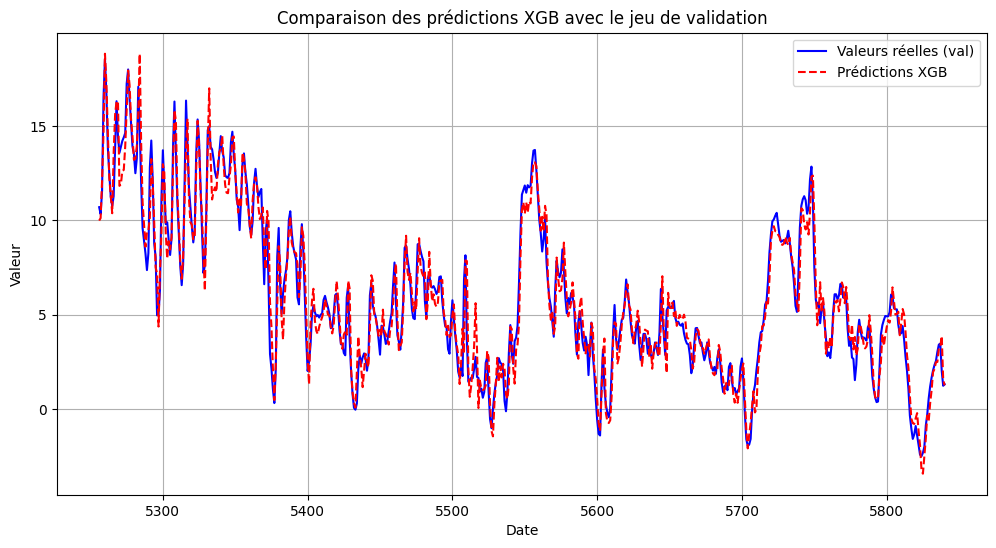

In [38]:
match_val_predict(p_xgb, y_test_xgb, 'XGB').show()

Les scores sont très bons et la courbe de validation montre que le modèle XGB généralise bien sur ce jeu. Il faut cependant rester attentif à l’overfitting, et vérifier que la séparation train/val est correcte et qu’il n’y a pas eu de fuite de données.Le MAPE élevé indique que le modèle a plus de mal sur les petites valeurs.

In [39]:
logger_manager.log_training('XGB', study.best_value, study.best_params, m_xgb)

✅ Logged XGB training parameters


### XGBoost + Exogène

In [61]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Paramètres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Paramètres XGBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)

    train_ml_numeric = train_ml.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Créer les lag features
        lag_transformer = LagFeatures(
            variables= ['y', 'relative_humidity_2m'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y', 'relative_humidity_2m'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y', 'relative_humidity_2m'])
        y_val = val_transformed['y']

        # Entraînement
        model = XGBRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            subsample=subsample,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)


In [62]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 61. Best value: 1.90017: 100%|██████████| 100/100 [01:35<00:00,  1.04it/s]


In [63]:
best_n_lags = study.best_params['n_lags']
best_params = study.best_params.copy()
best_params.pop('n_lags', None)

9

In [64]:
train_ml_numeric = train_ml.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml.select_dtypes(include=['number']).copy()

xgb_transformer = LagFeatures(
    variables=['y', 'relative_humidity_2m'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_xgb = xgb_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_xgb = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_xgb = xgb_transformer.transform(test_transformed_xgb).iloc[best_n_lags:].dropna()

X_train_xgb = train_transformed_xgb.drop(columns=['y', 'relative_humidity_2m'])
y_train_xgb = train_transformed_xgb['y']

X_test_xgb = test_transformed_xgb.drop(columns=['y', 'relative_humidity_2m'])
y_test_xgb = test_transformed_xgb['y']

xgb_r = XGBRegressor(**best_params, random_state=42)
xgb_r.fit(X_train_xgb, y_train_xgb)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.07344280797762961, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=233, n_jobs=None,
             num_parallel_tree=None, ...)

In [65]:
p_xgb = xgb_r.predict(X_test_xgb)

In [66]:
m_xgb = metrics_result(p_xgb, y_test_xgb)

MAPE : 57.7%
MAE : 0.78
RMSE : 1.03
R² : 0.936


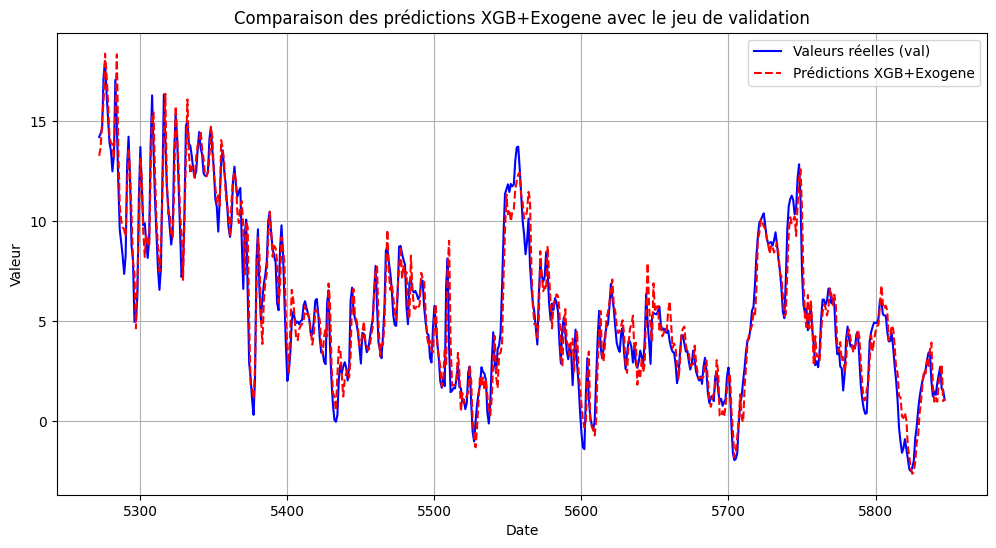

In [67]:
match_val_predict(p_xgb, y_test_xgb, 'XGB+Exogene').show()

L'expérimentation avec variables exogènes a été menée mais n'a pas apporté de gain de performance. Cela suggère que l'information pertinente est déjà captée par les lags de la température.

In [68]:
logger_manager.log_training('XGB+Exogene', study.best_value, study.best_params, m_xgb )

✅ Logged XGB+Exogene training parameters


### Random Forest

In [69]:
def objective(trial):
    mse_scores = []
    tscv = TimeSeriesSplit(n_splits=3)

    # Paramètres des lag features
    n_lags = trial.suggest_int('n_lags', 1, 10)

    # Paramètres Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    max_samples = trial.suggest_float('max_samples', 0.6, 1.0)

    train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number'])

    for train_idx, val_idx in tscv.split(train_ml_numeric):
        train_tss = train_ml_numeric.iloc[train_idx].copy()
        val_tss = train_ml_numeric.iloc[val_idx].copy()

        # Créer les lag features
        lag_transformer = LagFeatures(
            variables=['y'],
            periods=list(range(1, n_lags + 1))
        )

        # Appliquer les transformations
        train_transformed = lag_transformer.fit_transform(train_tss).dropna()
        last_n_lags = train_tss.tail(n_lags)
        val_init = pd.concat([last_n_lags, val_tss])

        val_transformed = lag_transformer.transform(val_init).iloc[n_lags:].dropna()

        if train_transformed.empty or val_transformed.empty:
            continue

        X_train = train_transformed.drop(columns=['y'])
        y_train = train_transformed['y']
        X_val = val_transformed.drop(columns=['y'])
        y_val = val_transformed['y']

        # Entraînement
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            max_features=max_features,
            max_samples=max_samples,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Prédiction
        y_pred = model.predict(X_val)
        mse_scores.append(mean_squared_error(y_val, y_pred))

    return np.mean(mse_scores)

In [70]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

Best trial: 42. Best value: 2.19392: 100%|██████████| 100/100 [09:20<00:00,  5.60s/it]


In [71]:
best_n_lags = study.best_params['n_lags']

best_params = study.best_params.copy()
best_params.pop('n_lags', None)

10

In [72]:
train_ml_numeric = train_ml_without_exog.select_dtypes(include=['number']).copy()
test_ml_numeric = test_ml_without_exog.select_dtypes(include=['number']).copy()

rf_transformer = LagFeatures(
    variables=['y'],
    periods=list(range(1, best_n_lags + 1))
)

train_transformed_rf = rf_transformer.fit_transform(train_ml_numeric).dropna()
last_n_lags = train_ml_numeric.tail(best_n_lags)
test_transformed_rf = pd.concat([last_n_lags, test_ml_numeric])

test_transformed_rf = rf_transformer.transform(test_ml_numeric).iloc[best_n_lags:].dropna()

X_train_rf = train_transformed_rf.drop(columns=['y'])
y_train_rf = train_transformed_rf['y']

X_test_rf = test_transformed_rf.drop(columns=['y'])
y_test_rf = test_transformed_rf['y']

r_rf = RandomForestRegressor(**best_params, random_state=42)
r_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=8, max_features=0.963070938397881,
                      max_samples=0.9855759887644548, n_estimators=187,
                      random_state=42)

In [73]:
p_rf = r_rf.predict(X_test_rf)

In [74]:
m_rf = metrics_result(p_rf, y_test_rf)

MAPE : 47.3%
MAE : 0.76
RMSE : 1.02
R² : 0.937


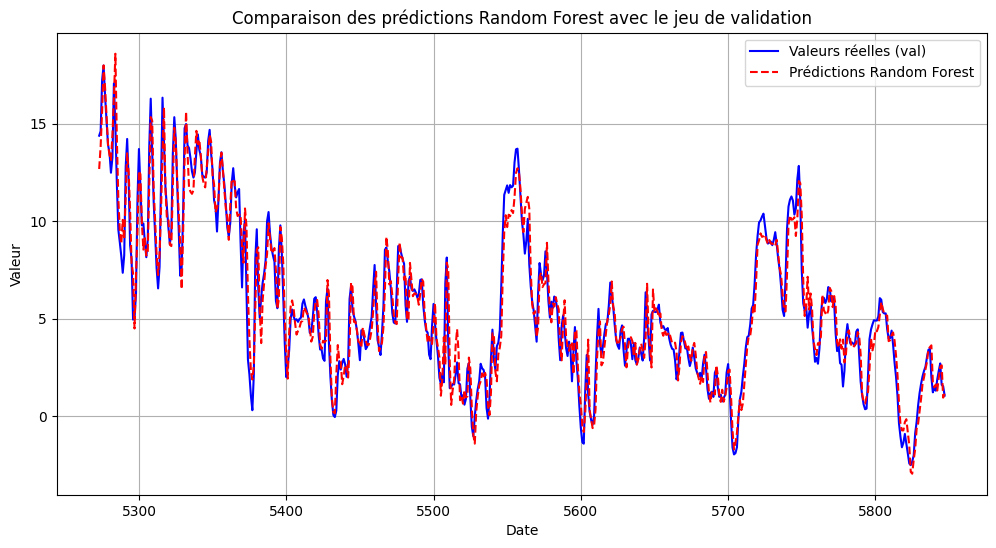

In [75]:
match_val_predict(p_rf, y_test_rf, 'Random Forest').show()

Le Random Forest capture très bien la dynamique de la série temporelle, mais il faut rester prudent avec l’interprétation du MAPE dans ce contexte. Les autres métriques et la visualisation montrent que le modèle est performant sur ce jeu de validation.

In [76]:
logger_manager.log_training('Random Forest', study.best_value, study.best_params, m_rf )

✅ Logged Random Forest training parameters
